In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from pandas.api.types import is_numeric_dtype

In [110]:
!pip install tensorflow

In [111]:
import tensorflow as tf

In [112]:
!pip install keras

In [113]:
!pip install scikeras

In [114]:
import keras
from keras.layers import Input
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
# from keras.layers import Flatten
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
from keras.callbacks import ModelCheckpoint, EarlyStopping

In [115]:
import sklearn
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [116]:
!pip install livelossplot
from livelossplot.tf_keras import PlotLossesCallback

In [117]:
!pip install shap
import shap

In [118]:
from google.cloud import bigquery

---------

### Authentication for working from Google Colab

In [119]:
# from google.colab import auth
# auth.authenticate_user()

---------

### Destination to save trained models

#### Google disk

In [120]:
# from google.colab import drive

# drive.mount('/content/gdrive')
# project_folder_path = '/content/gdrive/Shareddrives/Magisterka/PROJEKT/'
# models_path = project_folder_path + '/models'

#### Vertex AI Jupyter Lab

In [121]:
data_analysis_folder_path = '../'
models_path = data_analysis_folder_path + '/models'

---------

### Connect to Bigquery service

In [122]:
project_id = "master-thesis-2023-393813" # Fill project id
bqclient = bigquery.Client(project_id)

## Loading data

In [123]:
dataset_name = "twitbot_22_preprocessed_common_users_ids" #"twitbot_22_preprocessed"
users_table_name = "users"
BQ_TABLE_USERS = dataset_name + "." + users_table_name
table_id = project_id + "." + BQ_TABLE_USERS

In [124]:
job_config = bigquery.QueryJobConfig(
    allow_large_results=True, destination=table_id, use_legacy_sql=True
)

In [125]:
SQL_QUERY = f"""WITH 
  human_records AS (
    SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'human' 
    LIMIT 1000),
  bot_records AS (
  SELECT *, ROW_NUMBER() OVER () row_num 
    FROM {BQ_TABLE_USERS}
    WHERE label = 'bot' 
    LIMIT 1000)
  SELECT * FROM human_records 
    UNION ALL SELECT * 
    FROM bot_records 
    ORDER BY row_num;"""

users_df1 = bqclient.query(SQL_QUERY).to_dataframe()
users_df1 = users_df1.drop(['row_num'], axis=1)

In [126]:
# LIMIT RESULTS OPTIONS
pd.set_option('display.max_rows', 100)
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_column', None)
pd.set_option('display.max_colwidth', None)

In [127]:
num_bots = len(users_df1.loc[users_df1['label']=='bot'])       # bots number
num_humans = len(users_df1.loc[users_df1['label']=='human'])   # humans number

print("Number of real users: ", num_humans)
print("Number of bots: ", num_bots)

Number of real users:  1000
Number of bots:  1000


In [128]:
org_users_df = pd.DataFrame(users_df1).copy()
users_df2 = pd.DataFrame(org_users_df).copy()

#### Filter to have same number of record for each class - part I (second part after data analysis and reducing some of outliers)

In [129]:
def filter_df_for_balanced_classes(df, bot_label_value='bot', human_label_value='human'):
    new_df = pd.DataFrame()

    i = 0 # bots iter.
    j = 0 # humans iter.
    k = 0
    num_bots = len(df.loc[df['label']==bot_label_value])
    num_humans = len(df.loc[df['label']==human_label_value])
    max_num = min(num_bots, num_humans)
    for index, record in df.iterrows():
      if k < (2*max_num):
        if record['label']==bot_label_value and i < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          i += 1
          k += 1
        if record['label']==human_label_value and j < max_num:
          new_df = new_df.append(record)
          # users_df = pd.concat([users_df, record], ignore_index=True)
          j += 1
          k += 1
            
    print("Number of bots: ", len(new_df.loc[new_df['label']==bot_label_value]))
    print("Number of human users: ", len(new_df.loc[new_df['label']==human_label_value]))
    
    return pd.DataFrame(new_df).copy();

In [130]:
users_df = filter_df_for_balanced_classes(users_df2)

Number of bots:  1000
Number of human users:  1000


## Data preparation

In [131]:
def drop_columns(df, columns):
    for column_name in columns:
      df = df.drop([column_name], axis=1)
    return df

In [132]:
def encode_not_numeric_columns(df):
  for column_name in df:
    if not is_numeric_dtype(df[column_name]):
      unique_values_dict = dict(enumerate(df[column_name].unique()))
      unique_values_dict = dict((v, k) for k, v in unique_values_dict.items())
      df[column_name] = df[column_name].map(unique_values_dict)
  return df

#### Align values for bool columns

In [133]:
boolean_columns = ["verified", "protected", "withheld", "has_location", "has_profile_image_url", "has_pinned_tweet", "has_description"]

In [134]:
# Firstly align boolean columns values
for col_name in boolean_columns:
    users_df[col_name] = users_df[col_name].astype(bool)

column_to_remove = []
# Check unique values (some of subset can have only one unique value for some feature) if so it column will be removed from dataframe
for col_name in boolean_columns:
    uniq_val_list = users_df[col_name].unique()
    print("Column {:<24} {}".format(col_name, str(uniq_val_list)))
    if (len(uniq_val_list) < 2):
        column_to_remove.append(col_name)

Column verified                 [False  True]
Column protected                [False  True]
Column withheld                 [False]
Column has_location             [ True False]
Column has_profile_image_url    [ True False]
Column has_pinned_tweet         [False  True]
Column has_description          [ True False]


In [135]:
column_to_remove

['withheld']

In [136]:
# remove from bool columns:
for col_name in column_to_remove:
    boolean_columns.remove(col_name)
# remove from dataframe
users_df = drop_columns(users_df, column_to_remove)

### Encoding of non-numeric information which will be used by model

In [137]:
# Remap the values of the dataframe
for col_name in boolean_columns:
  users_df[col_name] = users_df[col_name].map({True:1,False:0})

# Remap label values human/bot for 0/1
label_col = "label"
users_df[label_col] = users_df[label_col].map({"human":0,"bot":1})


In [138]:
users_df

id  label         username  \
0     1428769922507751429      1  BotoxAesthetics   
1     1484544053572419585      0  blessing_xettry   
2      842202106324951040      1     Mark11474609   
3     1447956502443069446      0      menametaken   
4                21309002      1          Sjouzan   
...                   ...    ...              ...   
1995           2204275447      0        Bernal660   
1996             51908597      1      quantumtime   
1997           3085840133      0     StreamerNews   
1998   772220520334893056      1       jesslee87_   
1999  1039612842742140928      0      ceschretter   

                                name    created_at  verified  protected  \
0     dermalfillers Aesthetics botox  1.629480e+09         0          0   
1                   #Blessing xettry  1.642778e+09         0          0   
2                               Mark  1.489632e+09         0          0   
3                          winwinnie  1.634055e+09         0          0   
4                             Zuzana  1.235058e+09         0          0   
...                              ...           ...       ...        ...   
1995                     Bernal Leis  1.384922e+09         0          0   
1996  Quantum Time (Andy Mendelsohn)  1.246239e+09         0          0   
1997                   Streamer News  1.426056e+09         0          0   
1998                        Jess Lee  1.472947e+09         0          0   
1999          Catherine E. Schretter  1.536698e+09         0          0   

      has_location                        location  has_profile_image_url  \
0                1         London , United Kingdom                      1   
1                1                           Nepal                      1   
2                1          Kelvin Grove, Brisbane                      1   
3                1                      your walls                      1   
4                1                    Brighton, UK                      1   
...            ...                             ...                    ...   
1995             1            Newcastle-under-Lyme                      1   
1996             0                            None                      1   
1997             1  Email: Moblord@StreamerNews.tv                      1   
1998             0                            None                      1   
1999             1                   Virginia, USA                      1   

      has_pinned_tweet                      url  followers_count  \
0                    0  https://t.co/CBDBvXnRKv              2.0   
1                    0                                       0.0   
2                    0                                       3.0   
3                    0                                       0.0   
4                    0                                       3.0   
...                ...                      ...              ...   
1995                 0                                    3153.0   
1996                 0                                      33.0   
1997                 0  https://t.co/5qHhsKncVE          16209.0   
1998                 0                                      39.0   
1999                 0                                      82.0   

      following_count  tweet_count  listed_count  has_description  \
0                41.0          1.0           0.0                1   
1                24.0          1.0           0.0                1   
2                22.0          4.0           0.0                0   
3                20.0          1.0           0.0                1   
4                42.0          2.0           0.0                0   
...               ...          ...           ...              ...   
1995           4699.0      12053.0          25.0                1   
1996            850.0         42.0           0.0                1   
1997            771.0      11081.0         142.0                1   
1998             26.0          5.0           0.0     

#### Null and NaN statistics

In [139]:
for col_name in users_df:
    count1 = pd.isnull(users_df[col_name]).sum()
    print(col_name + ": " + str(count1))

id: 0
label: 0
username: 0
name: 0
created_at: 0
verified: 0
protected: 0
has_location: 0
location: 663
has_profile_image_url: 0
has_pinned_tweet: 0
url: 0
followers_count: 0
following_count: 0
tweet_count: 0
listed_count: 0
has_description: 0
description: 0
descr_no_hashtags: 0
descr_no_cashtags: 0
descr_no_mentions: 0
descr_no_urls: 0
url_no_urls: 0


#### Extract some information from dataframe to new columns

##### Description length

In [140]:
users_df['descr_len'] = users_df['description'].apply(len).astype(float)

##### Account age (in days) (sice 16.03.2022) (dataset data collected during the 20/01-15/03/2022 period)

In [141]:
from datetime import datetime

In [142]:
def cal_days_diff(a,b):
    A = a.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    B = b.replace(hour = 0, minute = 0, second = 0, microsecond = 0)
    return (A - B).days

def convert_unixtime_to_datetime(a):
    return datetime.utcfromtimestamp(a)

In [143]:
base_date = datetime(2022, 3, 16)
users_df['account_age'] = users_df.apply(lambda x: cal_days_diff(base_date, convert_unixtime_to_datetime(x.created_at)), axis=1).astype(float)

#### Reduce unnecessary columns

In [144]:
users_reduced_df = pd.DataFrame(users_df).copy()
# columns_to_drop = ["id", "username", "name", "created_at", "location", "url", "description"]
columns_to_drop = ["username", "name", "created_at", "location", "url", "description"]
users_reduced_df = drop_columns(users_reduced_df, columns_to_drop)
users_reduced_df

id  label  verified  protected  has_location  \
0     1428769922507751429      1         0          0             1   
1     1484544053572419585      0         0          0             1   
2      842202106324951040      1         0          0             1   
3     1447956502443069446      0         0          0             1   
4                21309002      1         0          0             1   
...                   ...    ...       ...        ...           ...   
1995           2204275447      0         0          0             1   
1996             51908597      1         0          0             0   
1997           3085840133      0         0          0             1   
1998   772220520334893056      1         0          0             0   
1999  1039612842742140928      0         0          0             1   

      has_profile_image_url  has_pinned_tweet  followers_count  \
0                         1                 0              2.0   
1                         1                 0              0.0   
2                         1                 0              3.0   
3                         1                 0              0.0   
4                         1                 0              3.0   
...                     ...               ...              ...   
1995                      1                 0           3153.0   
1996                      1                 0             33.0   
1997                      1                 0          16209.0   
1998                      1                 0             39.0   
1999                      1                 0             82.0   

      following_count  tweet_count  listed_count  has_description  \
0                41.0          1.0           0.0                1   
1                24.0          1.0           0.0                1   
2                22.0          4.0           0.0                0   
3                20.0          1.0           0.0                1   
4                42.0          2.0           0.0                0   
...               ...          ...           ...              ...   
1995           4699.0      12053.0          25.0                1   
1996            850.0         42.0           0.0                1   
1997            771.0      11081.0         142.0                1   
1998             26.0          5.0           0.0                0   
1999            221.0         36.0           0.0                1   

      descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                   0.0                0.0                0.0            0.0   
1                   0.0                0.0                0.0            0.0   
2                   0.0                0.0                0.0            0.0   
3                   1.0                0.0                0.0            0.0   
4                   0.0                0.0                0.0            0.0   
...                 ...                ...                ...            ...   
1995                0.0                0.0                0.0            0.0   
1996                0.0                0.0                0.0            0.0   
1997                0.0                0.0                0.0            0.0   
1998                0.0                0.0                0.0            0.0   
1999                0.0                0.0                0.0            0.0   

      url_no_urls  descr_len  account_age  
0             1.0      160.0        208.0  
1             0.0       72.0         54.0  
2             0.0        0.0       1826.0  
3             0.0       85.0        155.0  
4             0.0        0.0       4773.0  
...           ...        ...          ...  
1995          0.0       66.0       3038.0  
1996          0.0      119.0       4643.0  
1997          1.0       54.0       2562.0  
1998          0.0        0.0       2020.0  
1999          0.0       34.0       1282.0  

[2000 rows x 19 columns]

### Data type conversion (to float)

In [145]:
for (column_name, column_data) in users_reduced_df.iteritems():
    users_reduced_df[column_name] = users_reduced_df[column_name].astype(float)

### Data split for training, validation and testing

In [146]:
train_data, test_data = train_test_split(users_reduced_df, test_size=0.30, random_state=25, shuffle=True)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=25, shuffle=True)

### Create same dataframe for validation and test set to work with based on outliers analysis (done in later part)

In [147]:
val_data_wo_outliers = pd.DataFrame(val_data).copy()
test_data_wo_outliers = pd.DataFrame(test_data).copy()

### Describe trainig dataset

In [148]:
train_data.describe()

id        label     verified    protected  has_location  \
count  1.400000e+03  1400.000000  1400.000000  1400.000000   1400.000000   
mean   5.552011e+17     0.495000     0.047143     0.005000      0.666429   
std    6.109491e+17     0.500154     0.212020     0.070559      0.471657   
min    5.212300e+04     0.000000     0.000000     0.000000      0.000000   
25%    2.965472e+08     0.000000     0.000000     0.000000      0.000000   
50%    3.423773e+09     0.000000     0.000000     0.000000      1.000000   
75%    1.206088e+18     1.000000     0.000000     0.000000      1.000000   
max    1.493160e+18     1.000000     1.000000     1.000000      1.000000   

       has_profile_image_url  has_pinned_tweet  followers_count  \
count            1400.000000       1400.000000     1.400000e+03   
mean                0.999286          0.213571     7.392049e+03   
std                 0.026726          0.409974     5.731408e+04   
min                 0.000000          0.000000     0.000000e+00   
25%                 1.000000          0.000000     2.500000e+01   
50%                 1.000000          0.000000     2.265000e+02   
75%                 1.000000          0.000000     1.247500e+03   
max                 1.000000          1.000000     1.730667e+06   

       following_count    tweet_count  listed_count  has_description  \
count      1400.000000    1400.000000   1400.000000      1400.000000   
mean       1307.027857    6153.339286     93.359286         0.787857   
std        6169.413713   25809.735070    440.909615         0.408972   
min           0.000000       0.000000      0.000000         0.000000   
25%          62.750000      20.000000      0.000000         1.000000   
50%         252.000000     455.500000      2.000000         1.000000   
75%         857.750000    3389.000000     31.000000         1.000000   
max      160807.000000  497641.000000   9314.000000         1.000000   

       descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
count        1400.000000        1400.000000        1400.000000    1400.000000   
mean            0.437143           0.001429           0.313571       0.086429   
std             1.476639           0.037783           0.838385       0.334508   
min             0.000000           0.000000           0.000000       0.000000   
25%             0.000000           0.000000           0.000000       0.000000   
50%             0.000000           0.000000           0.000000       0.000000   
75%             0.000000           0.000000           0.000000       0.000000   
max            17.000000           1.000000           7.000000       4.000000   

       url_no_urls    descr_len  account_age  
count  1400.000000  1400.000000  1400.000000  
mean      0.547143    83.313571  2433.191429  
std       0.497950    59.814183  1635.652748  
min       0.000000     0.000000    30.000000  
25%       0.000000    20.000000   822.250000  
50%       1.000000    92.000000  2405.000000  
75%       1.000000   141.250000  3962.250000  
max       1.000000   171.000000  5577.000000

#### Describes training data for bots

In [149]:
train_data.loc[train_data['label']==1].describe()

id  label  verified   protected  has_location  \
count  6.930000e+02  693.0     693.0  693.000000    693.000000   
mean   6.831366e+17    1.0       0.0    0.007215      0.539683   
std    6.126362e+17    0.0       0.0    0.084695      0.498783   
min    6.066562e+06    1.0       0.0    0.000000      0.000000   
25%    1.039260e+09    1.0       0.0    0.000000      0.000000   
50%    8.692522e+17    1.0       0.0    0.000000      1.000000   
75%    1.273626e+18    1.0       0.0    0.000000      1.000000   
max    1.493160e+18    1.0       0.0    1.000000      1.000000   

       has_profile_image_url  has_pinned_tweet  followers_count  \
count             693.000000        693.000000       693.000000   
mean                0.998557          0.155844      1623.821068   
std                 0.037987          0.362970     14081.023065   
min                 0.000000          0.000000         0.000000   
25%                 1.000000          0.000000        10.000000   
50%                 1.000000          0.000000        67.000000   
75%                 1.000000          0.000000       338.000000   
max                 1.000000          1.000000    264663.000000   

       following_count    tweet_count  listed_count  has_description  \
count       693.000000     693.000000    693.000000       693.000000   
mean        749.165945    2987.904762     24.113997         0.662338   
std        3623.801003   21407.661411    106.537708         0.473254   
min           0.000000       0.000000      0.000000         0.000000   
25%          35.000000       6.000000      0.000000         0.000000   
50%         116.000000     118.000000      1.000000         1.000000   
75%         377.000000    1175.000000      5.000000         1.000000   
max       55699.000000  497641.000000   1655.000000         1.000000   

       descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
count         693.000000         693.000000         693.000000     693.000000   
mean            0.398268           0.002886           0.199134       0.067821   
std             1.484057           0.053683           0.658997       0.326597   
min             0.000000           0.000000           0.000000       0.000000   
25%             0.000000           0.000000           0.000000       0.000000   
50%             0.000000           0.000000           0.000000       0.000000   
75%             0.000000           0.000000           0.000000       0.000000   
max            17.000000           1.000000           5.000000       4.000000   

       url_no_urls   descr_len  account_age  
count   693.000000  693.000000   693.000000  
mean      0.454545   66.246753  2038.994228  
std       0.498289   61.038470  1540.530952  
min       0.000000    0.000000    30.000000  
25%       0.000000    0.000000   636.000000  
50%       0.000000   59.000000  1752.000000  
75%       1.000000  128.000000  3366.000000  
max       1.000000  162.000000  5419.000000

#### Describes training data for humans

In [150]:
train_data.loc[train_data['label']==0].describe()

id  label    verified   protected  has_location  \
count  7.070000e+02  707.0  707.000000  707.000000    707.000000   
mean   4.297989e+17    0.0    0.093352    0.002829      0.790665   
std    5.830523e+17    0.0    0.291131    0.053149      0.407122   
min    5.212300e+04    0.0    0.000000    0.000000      0.000000   
25%    1.454409e+08    0.0    0.000000    0.000000      1.000000   
50%    1.657765e+09    0.0    0.000000    0.000000      1.000000   
75%    1.040250e+18    0.0    0.000000    0.000000      1.000000   
max    1.492369e+18    0.0    1.000000    1.000000      1.000000   

       has_profile_image_url  has_pinned_tweet  followers_count  \
count                  707.0        707.000000     7.070000e+02   
mean                     1.0          0.270156     1.304605e+04   
std                      0.0          0.444354     7.905886e+04   
min                      1.0          0.000000     0.000000e+00   
25%                      1.0          0.000000     1.180000e+02   
50%                      1.0          0.000000     6.470000e+02   
75%                      1.0          1.000000     3.140500e+03   
max                      1.0          1.000000     1.730667e+06   

       following_count    tweet_count  listed_count  has_description  \
count       707.000000     707.000000    707.000000       707.000000   
mean       1853.842999    9256.091938    161.233380         0.910891   
std        7870.580797   29177.773807    603.968299         0.285103   
min           0.000000       0.000000      0.000000         0.000000   
25%         149.500000     129.500000      1.000000         1.000000   
50%         463.000000    1403.000000     13.000000         1.000000   
75%        1304.500000    6746.000000     76.500000         1.000000   
max      160807.000000  373395.000000   9314.000000         1.000000   

       descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
count         707.000000              707.0         707.000000     707.000000   
mean            0.475248                0.0           0.425743       0.104668   
std             1.469384                0.0           0.970421       0.341333   
min             0.000000                0.0           0.000000       0.000000   
25%             0.000000                0.0           0.000000       0.000000   
50%             0.000000                0.0           0.000000       0.000000   
75%             0.000000                0.0           0.000000       0.000000   
max            17.000000                0.0           7.000000       2.000000   

       url_no_urls   descr_len  account_age  
count   707.000000  707.000000   707.000000  
mean      0.637907  100.042433  2819.582744  
std       0.480946   53.587459  1635.005413  
min       0.000000    0.000000    32.000000  
25%       0.000000   55.000000  1280.000000  
50%       1.000000  116.000000  3121.000000  
75%       1.000000  148.000000  4319.500000  
max       1.000000  171.000000  5577.000000

# Data analysis

In [151]:
def get_dataframe_real_indexes(df, outliers_index_list):
    real_all_indexes = train_data.loc[train_data['label']==1].index
    oder_indexes = np.arange(len(real_all_indexes)) 

    indexes_df = pd.DataFrame({'real_index' : real_all_indexes, 'order_index' : oder_indexes})
    return list(indexes_df[indexes_df.order_index.isin(outliers_index_list)]['real_index'])

In [152]:
def outliers_KNN(data, column_name, n_neighbors=10, radius=5, title="", r1=48, r2=90, w=900, h=500, ydtick=2, xdtick=2, nbins=20,  th = 0.9):

    np.set_printoptions(threshold=np.inf)

    # create model
    nbrs = NearestNeighbors(n_neighbors = n_neighbors, radius=radius)
    # fit model
    data_2d = [ [ 0., x] for x in data[column_name].values]
    nbrs.fit(data_2d)

    neighbors_and_distances = nbrs.kneighbors(data_2d)
    distances = neighbors_and_distances[0]
    neighbors = neighbors_and_distances[1]
    # print(neighbors_and_distances[1])

    plt.figure(figsize=(15, 7))
    # plt.plot(distances.mean(axis=1))

    distances = pd.DataFrame(distances)
    distances_mean = pd.DataFrame(distances).mean(axis =1)
    # distances_mean.describe()
    
    outliers_index = np.where(distances_mean > th) 
    outliers_index = list(outliers_index)[0]
    outliers_index = [outliers_index[i] for i in range(len(outliers_index))]
    outliers_index_with_column_name = [[indx, data[column_name].values[indx]] for indx in outliers_index]
    outliers_index_sorted_by_column_name = sorted(outliers_index_with_column_name,key=lambda x: x[1])

    outliers = list(dict(outliers_index_sorted_by_column_name).values())
    outliers_indexes = list(dict(outliers_index_sorted_by_column_name).keys())

    print("Number of outliers: ", len(outliers))

    fig = make_subplots(specs=[[{"secondary_y": True}]])

    trace1 = go.Histogram(
            x=data[column_name],
            name=column_name,
            nbinsx=nbins,
            opacity=0.7,
    )
    trace2 = go.Histogram(
        x=outliers,
        nbinsx=nbins,
        # histnorm='density',
        name='outliers',
        opacity=0.7
    )

    traces = [trace1, trace2]
    layout = go.Layout(barmode='overlay')
    # layout = go.Layout()
    fig = go.Figure(data=traces, layout=layout)
    fig.update_layout(
        title_text=title, # title f plot
        xaxis_title_text='value', # xaxis label
        yaxis_title_text='frequency', # yaxis label
        bargap=0.05,
        bargroupgap=0.05
    )

    # fig.update_xaxes(dtick=xdtick, range =[r1,r2])
    # fig.update_yaxes(dtick=ydtick)
    fig.update_layout(
        width=w,
        height=h)
    fig.show()
    
    return get_dataframe_real_indexes(data, outliers_index)

## Distribution of label class in training, validation and test set

In [153]:
stack_data = {'Set': ['Training data', 'Validation data', 'Test data', 'Training data', 'Validation data', 'Test data'],
              'Label': ['Bot', 'Bot', 'Bot', 'Human', 'Human', 'Human'],
              'Freq': [len(train_data.loc[train_data['label']==1]), 
                       len(val_data.loc[val_data['label']==1]), 
                       len(test_data.loc[test_data['label']==1]),
                       len(train_data.loc[train_data['label']==0]), 
                       len(val_data.loc[val_data['label']==0]), 
                       len(test_data.loc[test_data['label']==0])]}
sdf = pd.DataFrame(stack_data)
sdf

Set  Label  Freq
0    Training data    Bot   693
1  Validation data    Bot   147
2        Test data    Bot   160
3    Training data  Human   707
4  Validation data  Human   153
5        Test data  Human   140

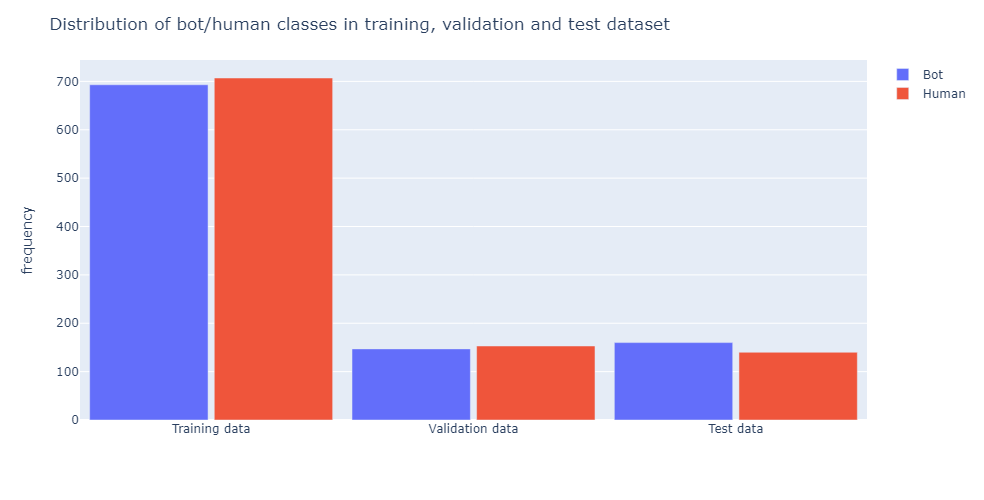

In [154]:
fig = px.bar(sdf, x="Set", y="Freq",
             color="Label", hover_data=['Label'],
             barmode = 'group')
fig.update_layout(
    title_text='Distribution of bot/human classes in training, validation and test dataset',
    xaxis_title_text='', #'subset',
    yaxis_title_text='frequency',
    bargap=0.05,
    bargroupgap=0.05,
    width=700,
    height=500,
    legend={"title":""})
fig.show()

## Distribution of other features in training dataset

### ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']

In [155]:
train_bot_data = train_data.loc[train_data['label']==1]
train_human_data = train_data.loc[train_data['label']==0]

# stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_profile_image_url', 'has_pinned_tweet', 'has_description']*4,
#     'Label': ['Bot']*12 + ['Human']*12,
#     'Value': [True]*6 + [False]*6 + [True]*6 + [False]*6,
stack_bool_training_feature_data = {'Feature': ['verified', 'protected', 'has_location', 'has_pinned_tweet', 'has_description']*4,
    'Label': ['Bot']*10 + ['Human']*10,
    'Value': [True]*5 + [False]*5 + [True]*5 + [False]*5,
    'Freq': [len(train_bot_data.loc[train_bot_data['verified']==1]), 
             len(train_bot_data.loc[train_bot_data['protected']==1]), 
             len(train_bot_data.loc[train_bot_data['has_location']==1]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==1]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==1]), 
             len(train_bot_data.loc[train_bot_data['has_description']==1]),
             len(train_bot_data.loc[train_bot_data['verified']==0]), 
             len(train_bot_data.loc[train_bot_data['protected']==0]), 
             len(train_bot_data.loc[train_bot_data['has_location']==0]),
             # len(train_bot_data.loc[train_bot_data['has_profile_image_url']==0]), 
             len(train_bot_data.loc[train_bot_data['has_pinned_tweet']==0]), 
             len(train_bot_data.loc[train_bot_data['has_description']==0]),
             len(train_human_data.loc[train_human_data['verified']==1]), 
             len(train_human_data.loc[train_human_data['protected']==1]), 
             len(train_human_data.loc[train_human_data['has_location']==1]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==1]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==1]), 
             len(train_human_data.loc[train_human_data['has_description']==1]),
             len(train_human_data.loc[train_human_data['verified']==0]), 
             len(train_human_data.loc[train_human_data['protected']==0]), 
             len(train_human_data.loc[train_human_data['has_location']==0]),
             # len(train_human_data.loc[train_human_data['has_profile_image_url']==0]), 
             len(train_human_data.loc[train_human_data['has_pinned_tweet']==0]), 
             len(train_human_data.loc[train_human_data['has_description']==0])]}

stack_training_bool_feature_df = pd.DataFrame(stack_bool_training_feature_data)

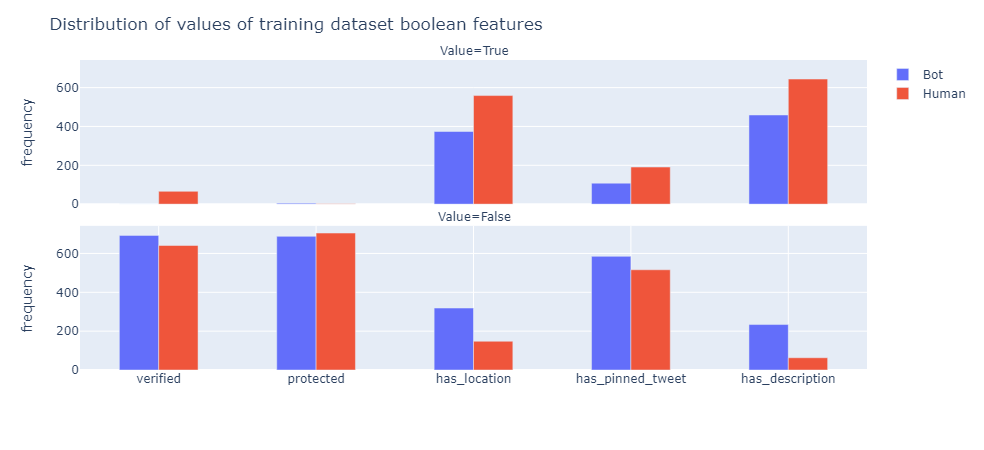

In [156]:
fig = px.bar(stack_training_bool_feature_df, 
               x="Feature", 
               y="Freq",
               facet_col="Value",
               facet_col_wrap = 1,
               color="Label", hover_data=['Label'],
               barmode = 'group')
fig.update_layout(
    title_text='Distribution of values of training dataset boolean features',
    xaxis_title_text='', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True),
    yaxis=dict(showgrid=True))

fig.update_yaxes(row=2, col=1, title='frequency')
fig.show()

### followers_count

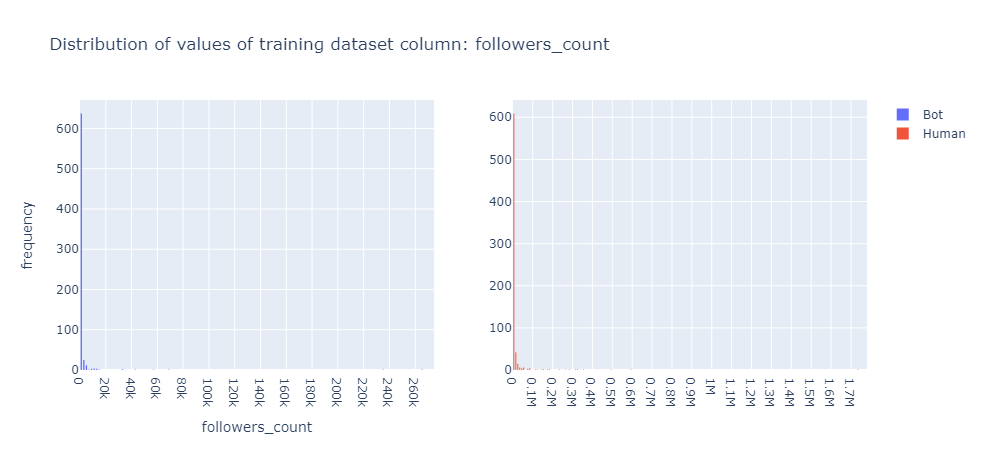

In [157]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True,title='followers_count', dtick=20000, range=[0, max(train_data.loc[train_data['label']==1,'followers_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=100000, range=[0, max(train_data.loc[train_data['label']==0,'followers_count'])+50000]),
    yaxis=dict(showgrid=True))

fig.show()

#### followers_count - outliers

##### K-means (mnonot useful)

Number of outliers:  153


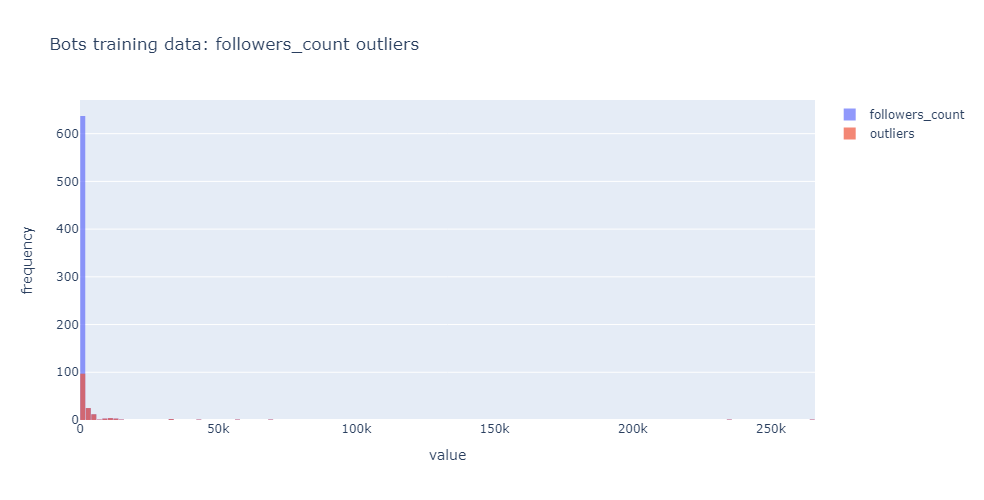

<Figure size 1500x700 with 0 Axes>

In [158]:
followers_count_bots_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==1], 'followers_count', title = "Bots training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

Number of outliers:  375


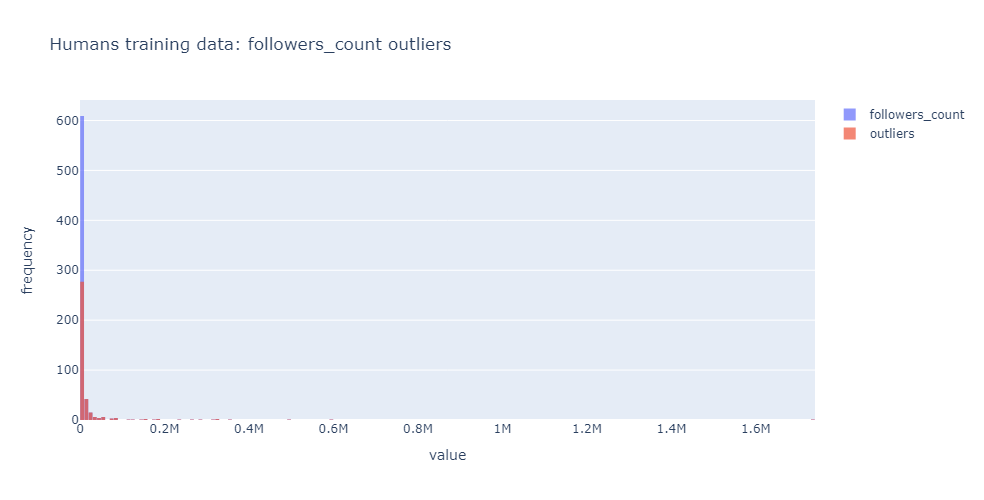

<Figure size 1500x700 with 0 Axes>

In [159]:
followers_count_humans_outliers_indexes = outliers_KNN(train_data.loc[train_data['label']==0], 'followers_count', title = "Humans training data: followers_count outliers", n_neighbors=2, radius=1, nbins=200)

In [160]:
# q_hi_bots = train_data.loc[train_data['label']==1]['followers_count'].quantile(0.99, interpolation='nearest')
# q_hi_humans = train_data.loc[train_data['label']==0]['followers_count'].quantile(0.99, interpolation='nearest')

# df_filtered_bots = train_data.loc[train_data['label']==1][(train_data.loc[train_data['label']==1]['followers_count'] < q_hi_bots)]
# df_filtered_humans = train_data.loc[train_data['label']==0][(train_data.loc[train_data['label']==0]['followers_count'] < q_hi_humans)]

In [161]:
len(train_data[(train_data['label']==1)])

693

In [162]:
len(train_data[(train_data['label']==0)])

707

In [163]:
from scipy.stats import expon

# Fit an exponential distribution to data
loc_b, scale_b = expon.fit(train_data.loc[train_data['label']==1]['followers_count'])
loc_h, scale_h = expon.fit(train_data.loc[train_data['label']==0]['followers_count'])

# Calculate the 99th percentile using the percent-point function (inverse CDF)
percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
df_reduced_outliers_followers_count = train_data[((train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)) | ((train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans))]
df_filtered_bots = train_data[(train_data['label']==1) & (train_data['followers_count'] < percentile_99_bots)]
df_filtered_humans = train_data[(train_data['label']==0) & (train_data['followers_count'] < percentile_99_humans)]

In [164]:
def df_99_percentile(df, column_name):
    # Fit an exponential distribution to data
    loc_b, scale_b = expon.fit(df.loc[df['label']==1][column_name])
    loc_h, scale_h = expon.fit(df.loc[df['label']==0][column_name])

    # Calculate the 99th percentile using the percent-point function (inverse CDF)
    percentile_99_bots = expon.ppf(0.99, loc=loc_b, scale=scale_b)
    percentile_99_humans = expon.ppf(0.99, loc=loc_h, scale=scale_h)
    return df[((df['label']==1) & (df[column_name] < percentile_99_bots)) | ((df['label']==0) & (df[column_name] < percentile_99_humans))]

In [165]:
len(df_filtered_bots)

674

In [166]:
len(df_filtered_humans)

682

In [167]:
len(df_reduced_outliers_followers_count) 

1356

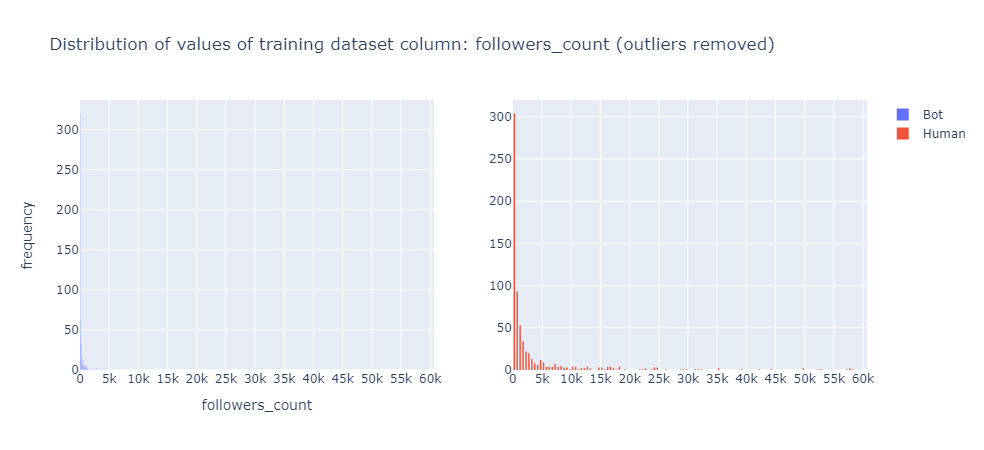

In [168]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==1,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_followers_count.loc[df_reduced_outliers_followers_count['label']==0,'followers_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: followers_count (outliers removed)',
    xaxis_title_text='followers_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    xaxis2=dict(showgrid=True, dtick=5000, range=[0, max(df_reduced_outliers_followers_count['followers_count'])+2500]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count

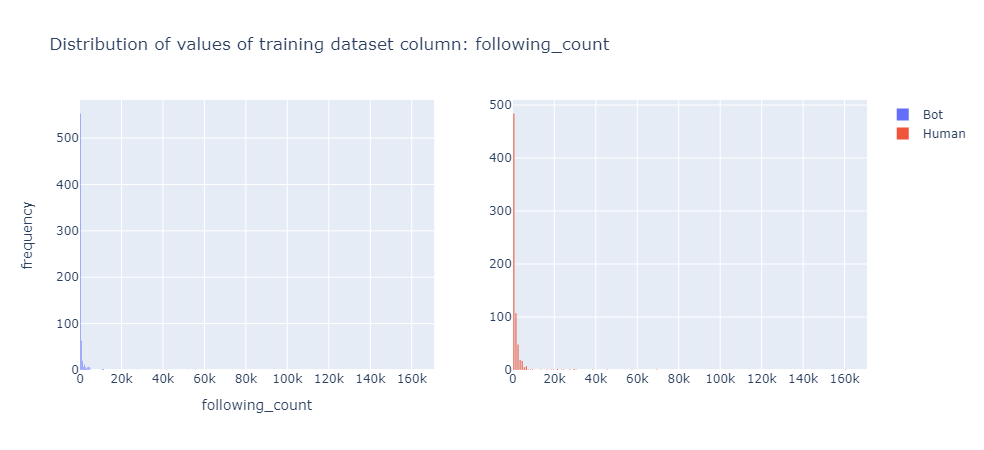

In [169]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    xaxis2=dict(showgrid=True, dtick=20000, range=[0, max(train_data['following_count'])+10000]),
    yaxis=dict(showgrid=True))

fig.show()

#### following_count - outliers

In [170]:
df_reduced_outliers_following_count = df_99_percentile(df=train_data, column_name='following_count')

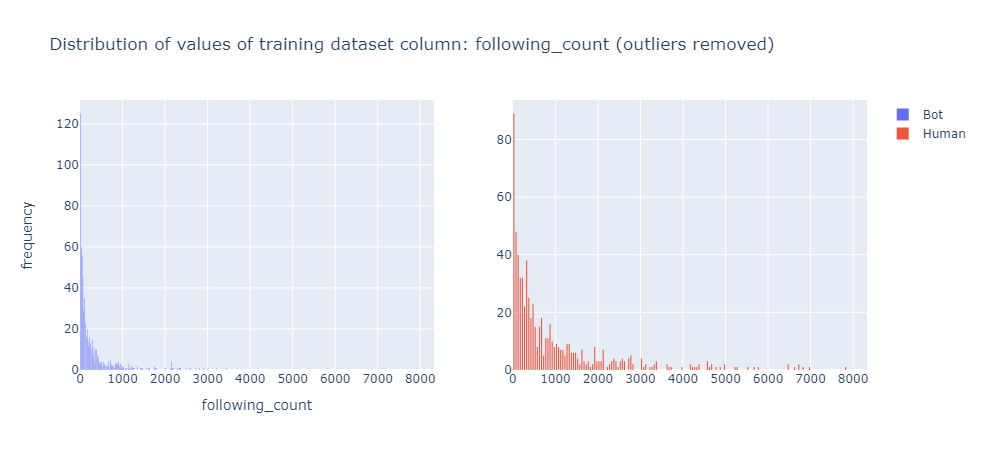

In [171]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==1,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_following_count.loc[df_reduced_outliers_following_count['label']==0,'following_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: following_count (outliers removed)',
    xaxis_title_text='following_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(df_reduced_outliers_following_count['following_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count

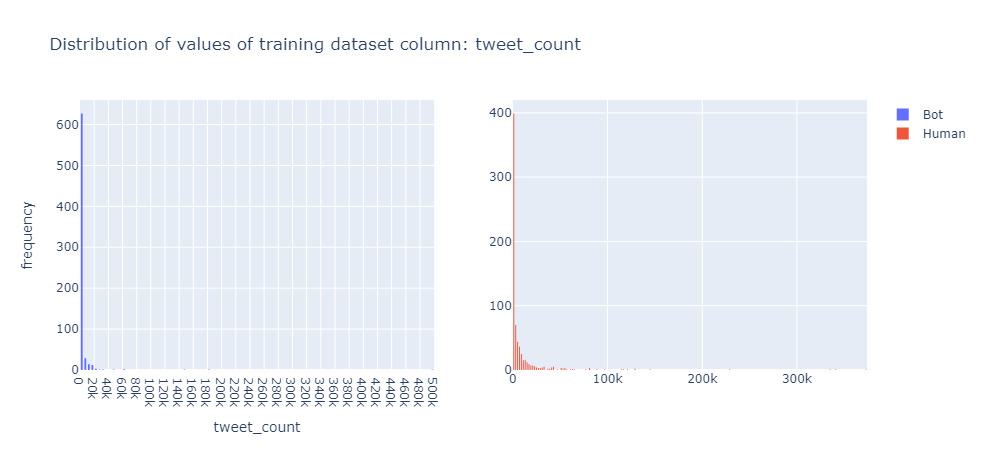

In [172]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=20000),
    xaxis2=dict(showgrid=True, dtick=100000),
    yaxis=dict(showgrid=True))

fig.show()

#### tweet_count - outliers

In [173]:
df_reduced_outliers_tweet_count = df_99_percentile(df=train_data, column_name='tweet_count')

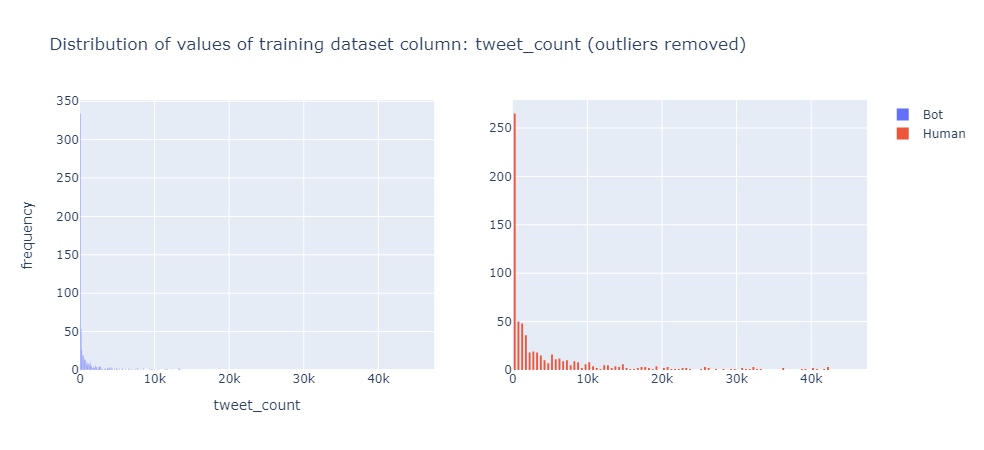

In [174]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==1,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_tweet_count.loc[df_reduced_outliers_tweet_count['label']==0,'tweet_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: tweet_count (outliers removed)',
    xaxis_title_text='tweet_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+5000]),
    xaxis2=dict(showgrid=True, dtick=10000, range=[0, max(df_reduced_outliers_tweet_count['tweet_count'])+5000]),
    yaxis=dict(showgrid=True))

fig.show()

### listed_count

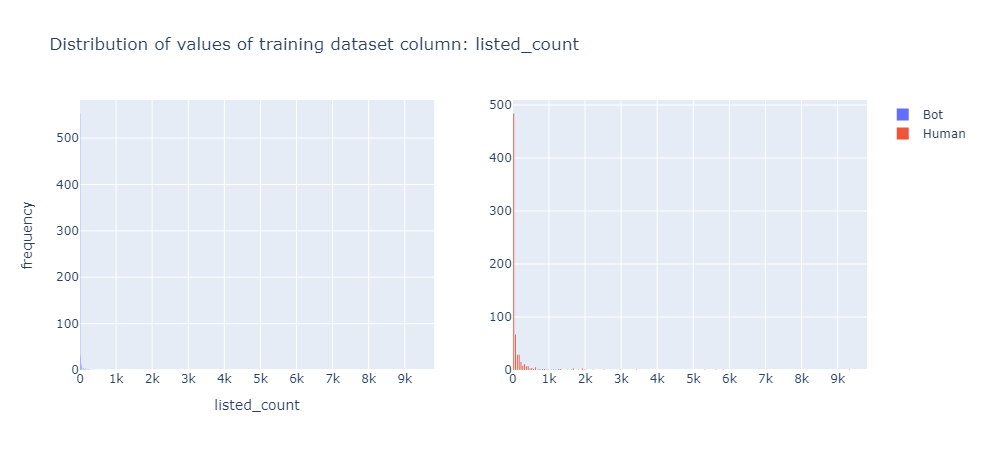

In [175]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1000, range=[0, max(train_data['listed_count'])+500]),
    xaxis2=dict(showgrid=True, dtick=1000, range=[0, max(train_data['listed_count'])+500]),
    yaxis=dict(showgrid=True))

fig.show()

#### listed_count - outliers

In [176]:
df_reduced_outliers_listed_count = df_99_percentile(df=train_data, column_name='listed_count')

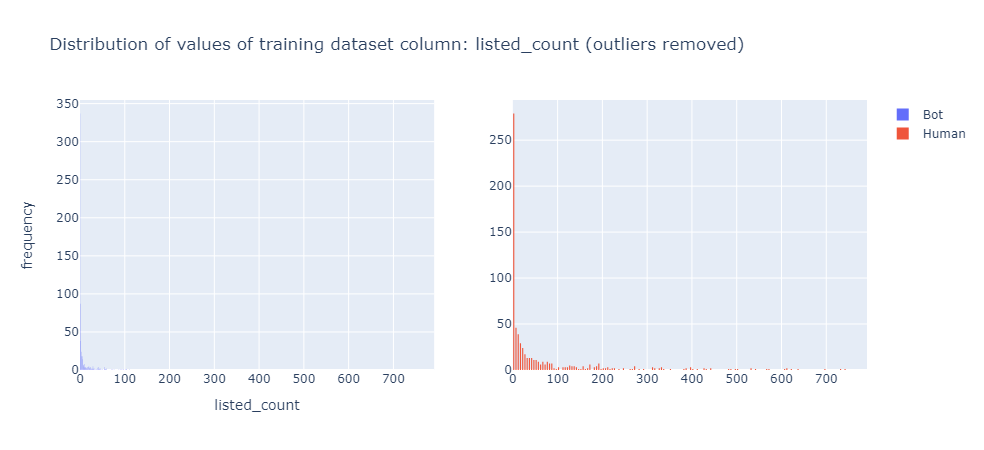

In [177]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==1,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_listed_count.loc[df_reduced_outliers_listed_count['label']==0,'listed_count'],
    # histnorm='density',
    nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: listed_count (outliers removed)',
    xaxis_title_text='listed_count', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=100, range=[0, max(df_reduced_outliers_listed_count['listed_count'])+50]),
    xaxis2=dict(showgrid=True, dtick=100, range=[0, max(df_reduced_outliers_listed_count['listed_count'])+50]),
    yaxis=dict(showgrid=True))

fig.show()

### ['descr_no_hashtags', 'descr_no_cashtags', 'descr_no_mentions', 'descr_no_urls', 'descr_len', 'url_no_urls']

### descr_no_hashtags

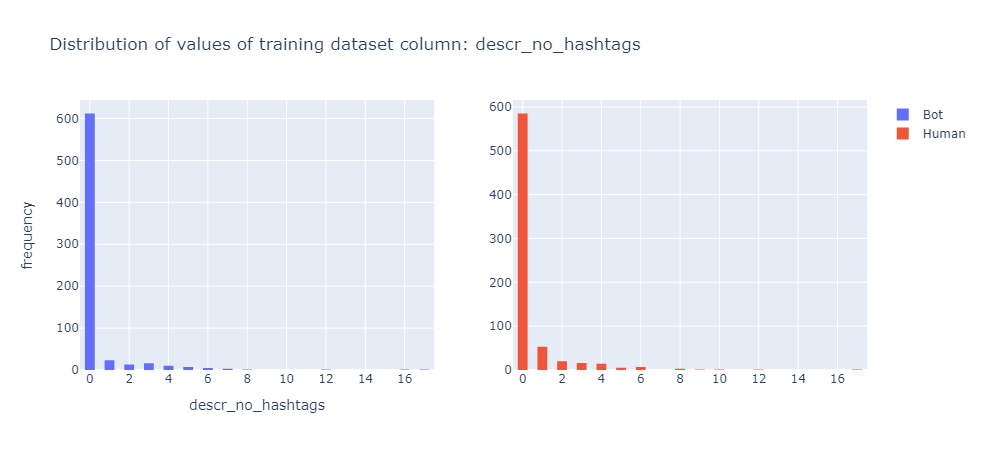

In [178]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=2),
    xaxis2=dict(showgrid=True, dtick=2),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_hashtags - outliers

In [179]:
df_reduced_outliers_descr_no_hashtags = df_99_percentile(df=train_data, column_name='descr_no_hashtags')

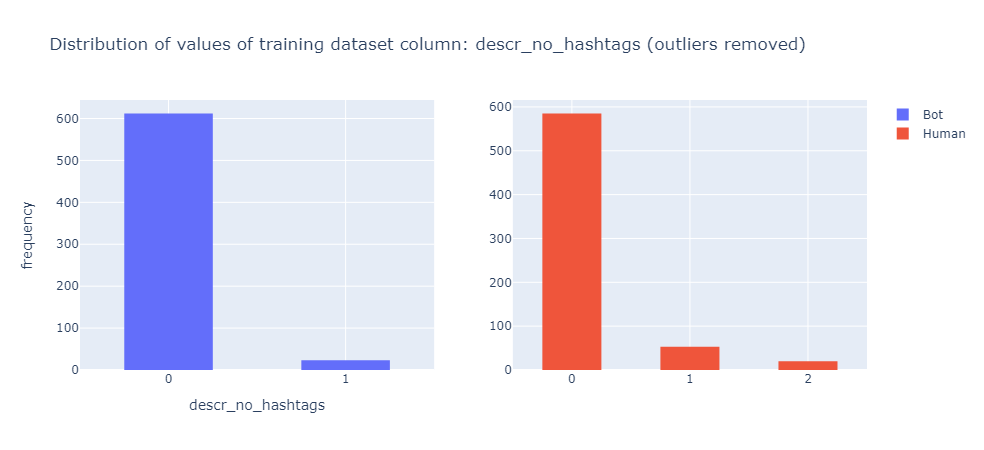

In [180]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==1,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_hashtags.loc[df_reduced_outliers_descr_no_hashtags['label']==0,'descr_no_hashtags'],
    # histnorm='density',
    # nbinsx=200,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_hashtags (outliers removed)',
    xaxis_title_text='descr_no_hashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.5,
    bargroupgap=None, #0.8,
    width=1100,
    height=450,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_cashtags


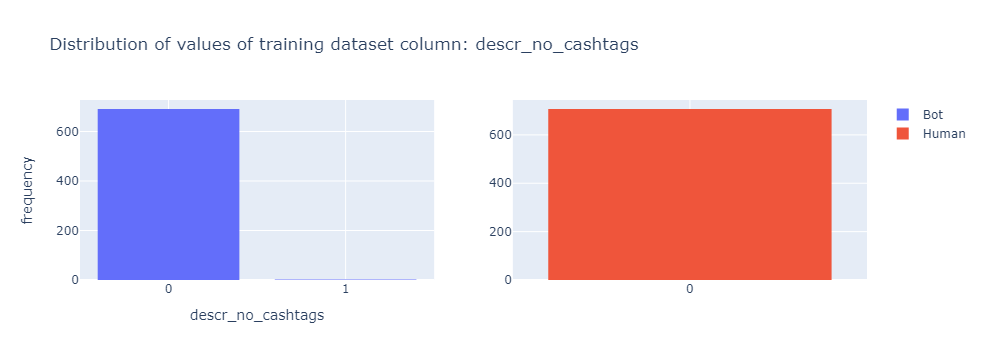

In [181]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_cashtags - outliers

In [182]:
df_reduced_outliers_descr_no_cashtags = df_99_percentile(df=train_data, column_name='descr_no_cashtags')

/opt/conda/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning:

invalid value encountered in multiply



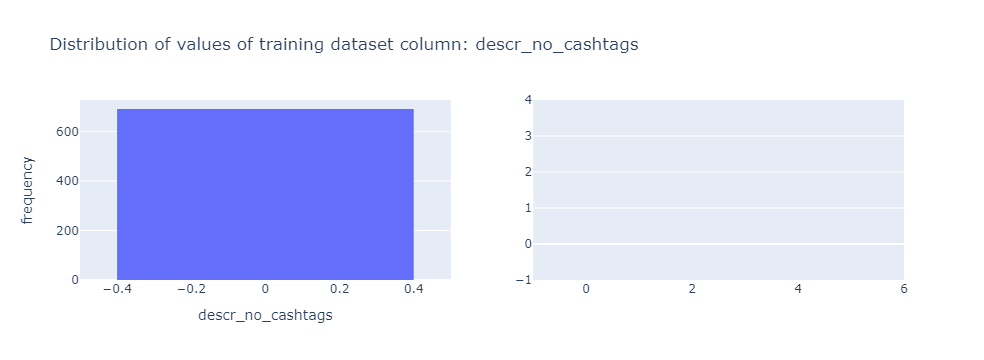

In [183]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==1,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_cashtags.loc[df_reduced_outliers_descr_no_cashtags['label']==0,'descr_no_cashtags'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_cashtags',
    xaxis_title_text='descr_no_cashtags', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    # xaxis=dict(showgrid=True, dtick=1),
    # xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### descr_no_mentions

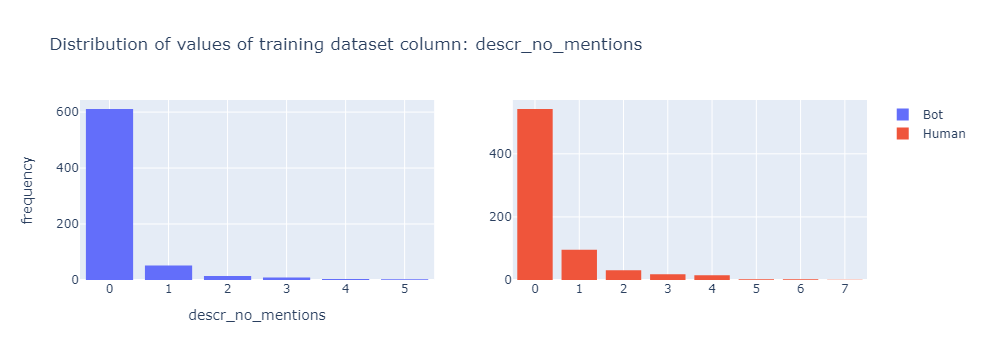

In [184]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_mentions - outliers

In [185]:
df_reduced_outliers_descr_no_mentions = df_99_percentile(df=train_data, column_name='descr_no_mentions')

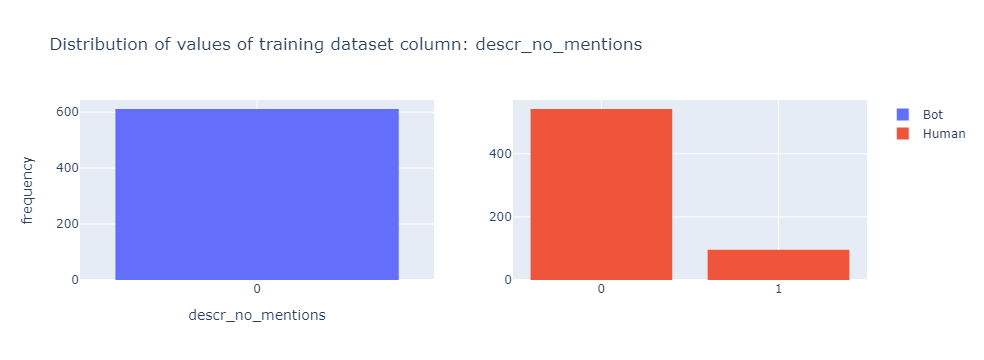

In [186]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_mentions.loc[df_reduced_outliers_descr_no_mentions['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_no_urls

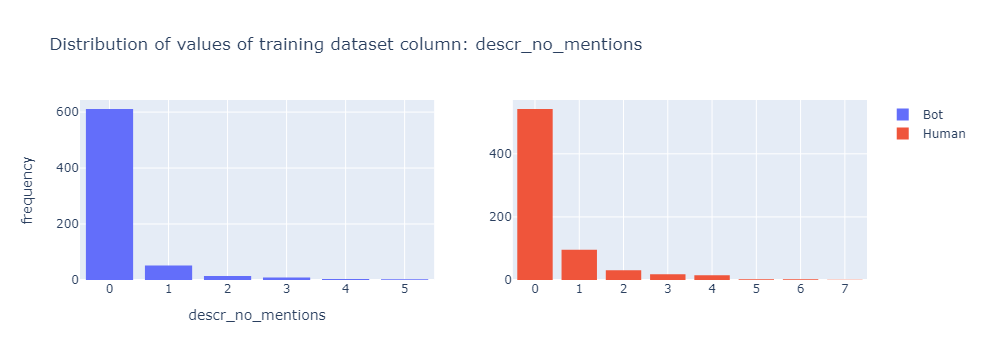

In [187]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_no_mentions'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_mentions',
    xaxis_title_text='descr_no_mentions', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_no_urls - outliers

In [188]:
df_reduced_outliers_descr_no_urls = df_99_percentile(df=train_data, column_name='descr_no_urls')

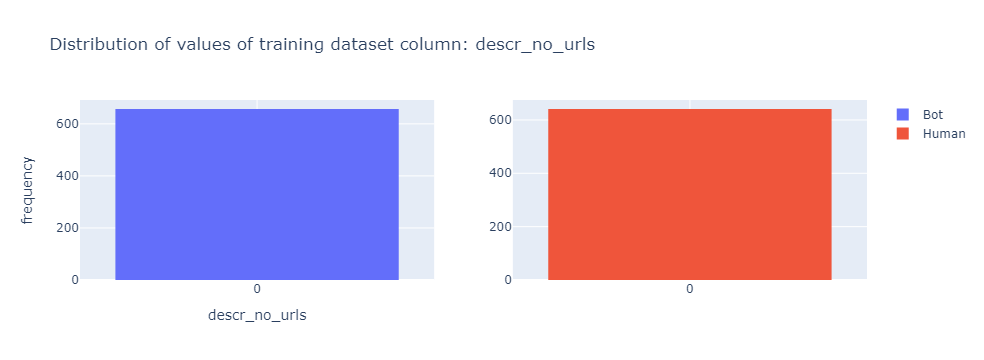

In [189]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==1,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_no_urls.loc[df_reduced_outliers_descr_no_urls['label']==0,'descr_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_no_urls',
    xaxis_title_text='descr_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

Better to drop this column (DONE, droped later)

### url_no_urls

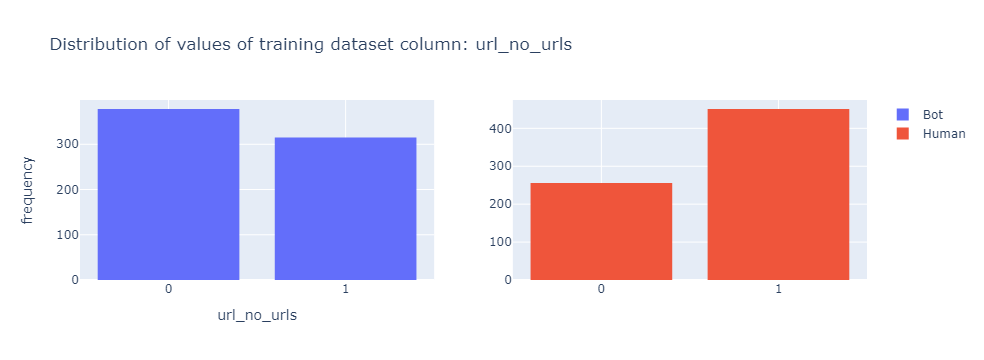

In [190]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

#### url_no_urls - outliers

In [191]:
df_reduced_outliers_url_no_urls = df_99_percentile(df=train_data, column_name='url_no_urls')

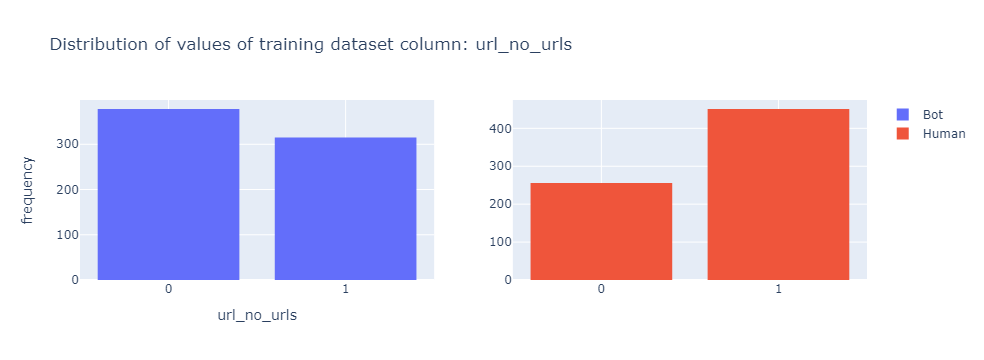

In [192]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==1,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_url_no_urls.loc[df_reduced_outliers_url_no_urls['label']==0,'url_no_urls'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: url_no_urls',
    xaxis_title_text='url_no_urls', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=1),
    xaxis2=dict(showgrid=True, dtick=1),
    yaxis=dict(showgrid=True))

fig.show()

### descr_len

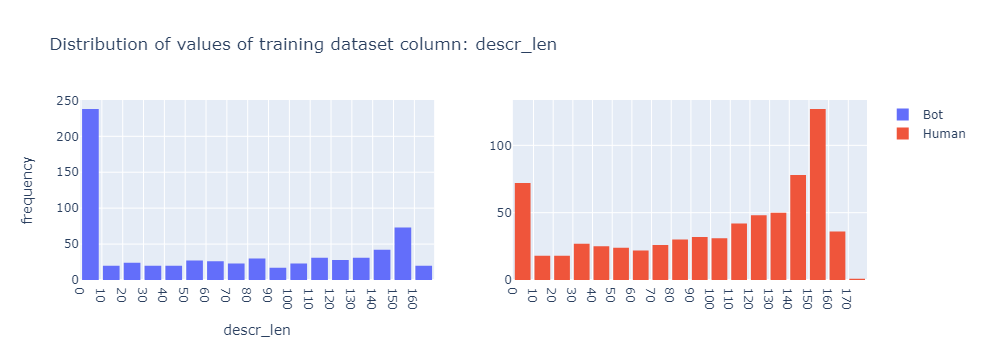

In [193]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

#### descr_len - outliers

In [194]:
q_hi_bots1 = train_data.loc[train_data['label']==1]['descr_len'].quantile(0.99, interpolation='nearest')
q_hi_humans1 = train_data.loc[train_data['label']==0]['descr_len'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_descr_len =  train_data[((train_data['label']==1) & (train_data['descr_len'] < q_hi_bots1)) | ((train_data['label']==0) & (train_data['descr_len'] < q_hi_humans1))]

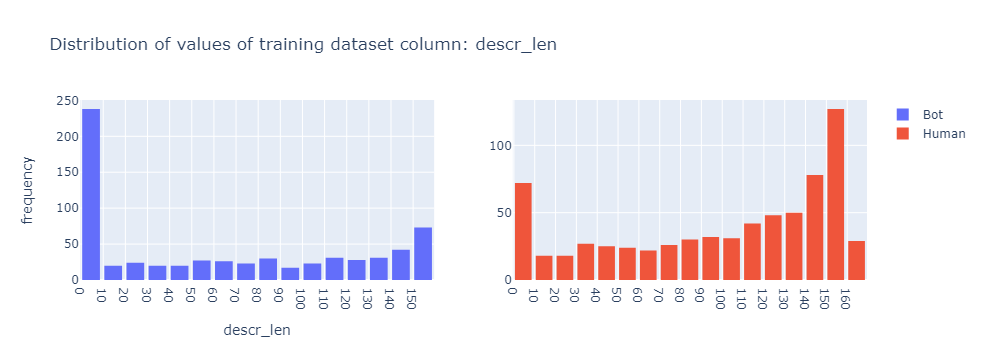

In [195]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==1,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_descr_len.loc[df_reduced_outliers_descr_len['label']==0,'descr_len'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: descr_len',
    xaxis_title_text='descr_len', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=10),
    xaxis2=dict(showgrid=True, dtick=10),
    yaxis=dict(showgrid=True))

fig.show()

### account_age

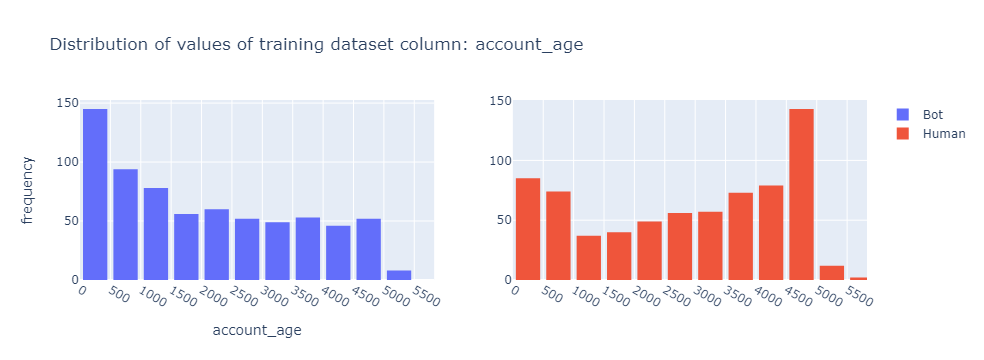

In [196]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=train_data.loc[train_data['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(train_data['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

#### account_age - outliers

In [197]:
q_hi_bots2 = train_data.loc[train_data['label']==1]['account_age'].quantile(0.99, interpolation='nearest')
q_hi_humans2 = train_data.loc[train_data['label']==0]['account_age'].quantile(0.99, interpolation='nearest')

df_reduced_outliers_account_age =  train_data[((train_data['label']==1) & (train_data['account_age'] < q_hi_bots2)) | ((train_data['label']==0) & (train_data['account_age'] < q_hi_humans2))]

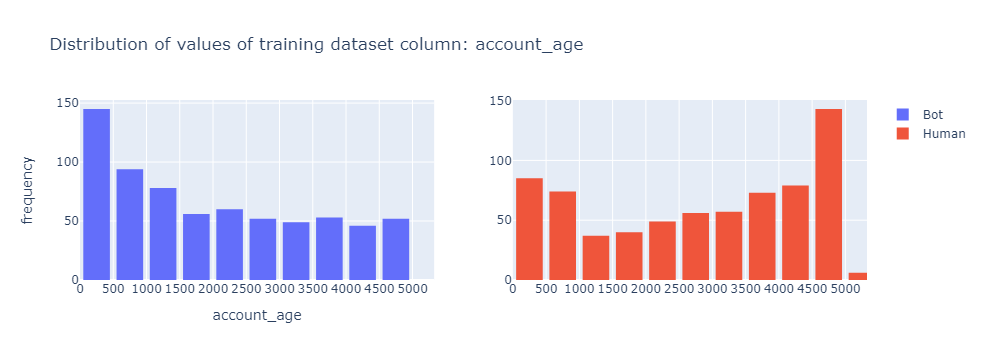

In [198]:
fig = go.Figure()
fig = make_subplots(rows=1, cols=2, specs=[[{'type':'histogram'}, {'type':'histogram'}]])

fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==1,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Bot'),
row=1, col=1
)
fig.add_trace(go.Histogram(
    x=df_reduced_outliers_account_age.loc[df_reduced_outliers_account_age['label']==0,'account_age'],
    # histnorm='density',
    # nbinsx=30,
    name='Human'),
row=1, col=2
)

fig.update_layout(
    title_text='Distribution of values of training dataset column: account_age',
    xaxis_title_text='account_age', #'feature',
    yaxis_title_text='frequency',
    bargap=0.2,
    bargroupgap=None, #0.8,
    width=1100,
    height=350,
    legend={"title":""},
    xaxis=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    xaxis2=dict(showgrid=True, dtick=500, range=[0, max(df_reduced_outliers_account_age['account_age'])+250]),
    yaxis=dict(showgrid=True))

fig.show()

### Create merged dataframe from reduced by columns outliers dataframes

In [199]:
train_data_wo_outliers = df_reduced_outliers_followers_count.merge(df_reduced_outliers_following_count, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

rest_of_df = [df_reduced_outliers_tweet_count, 
              df_reduced_outliers_listed_count, 
              df_reduced_outliers_descr_no_hashtags, 
              df_reduced_outliers_descr_no_cashtags,
              df_reduced_outliers_descr_no_mentions,
              df_reduced_outliers_descr_no_urls,
              df_reduced_outliers_url_no_urls,
              df_reduced_outliers_descr_len,
              df_reduced_outliers_account_age]

for df in rest_of_df:
    if (len(df.loc[df['label']==1]) > 0 and len(df.loc[df['label']==0]) > 0):
        train_data_wo_outliers = train_data_wo_outliers.merge(df, on ='id', how='inner', suffixes=('', '_DROP')).filter(regex='^(?!.*_DROP)')

In [200]:
len(train_data)

1400

In [201]:
len(train_data_wo_outliers)

966

In [202]:
train_data_wo_outliers

id  label  verified  protected  has_location  \
0    6.445578e+07    1.0       0.0        0.0           1.0   
1    2.833847e+09    1.0       0.0        0.0           0.0   
2    1.278718e+18    1.0       0.0        0.0           1.0   
3    3.312330e+09    1.0       0.0        0.0           1.0   
4    1.577382e+07    0.0       0.0        0.0           1.0   
..            ...    ...       ...        ...           ...   
961  4.953350e+08    0.0       0.0        0.0           1.0   
962  2.793700e+08    0.0       0.0        0.0           0.0   
963  8.724894e+07    0.0       0.0        0.0           1.0   
964  1.931782e+09    1.0       0.0        0.0           0.0   
965  1.418035e+09    1.0       0.0        0.0           0.0   

     has_profile_image_url  has_pinned_tweet  followers_count  \
0                      1.0               0.0           1419.0   
1                      1.0               0.0             43.0   
2                      1.0               1.0            457.0   
3                      1.0               0.0            726.0   
4                      1.0               0.0             22.0   
..                     ...               ...              ...   
961                    1.0               0.0           1847.0   
962                    1.0               0.0            131.0   
963                    1.0               0.0           1818.0   
964                    1.0               0.0             12.0   
965                    1.0               0.0             65.0   

     following_count  tweet_count  listed_count  has_description  \
0              309.0       1210.0          24.0              1.0   
1              258.0        440.0           4.0              1.0   
2              128.0        213.0           0.0              0.0   
3              177.0        831.0          19.0              1.0   
4              162.0         61.0           0.0              0.0   
..               ...          ...           ...              ...   
961           1166.0       8953.0         122.0              1.0   
962            162.0        244.0           9.0              1.0   
963            921.0       8957.0          62.0              1.0   
964            117.0        670.0           0.0              1.0   
965             74.0      12467.0          54.0              0.0   

     descr_no_hashtags  descr_no_cashtags  descr_no_mentions  descr_no_urls  \
0                  0.0                0.0                0.0            0.0   
1                  0.0                0.0                0.0            0.0   
2                  0.0                0.0                0.0            0.0   
3                  1.0                0.0                0.0            0.0   
4                  0.0                0.0                0.0            0.0   
..                 ...                ...                ...            ...   
961                0.0                0.0                0.0            0.0   
962                0.0                0.0                0.0            0.0   
963                0.0                0.0                0.0            0.0   
964                0.0                0.0                0.0            0.0   
965                0.0                0.0                0.0            0.0   

     url_no_urls  descr_len  account_age  
0            1.0      101.0       4601.0  
1            1.0      128.0       2708.0  
2            0.0        0.0        622.0  
3            1.0       65.0       2409.0  
4            0.0        0.0       4968.0  
..           ...        ...          ...  
961          1.0      159.0       3680.0  
962          0.0       60.0       3994.0  
963          1.0       42.0       4516.0  
964          1.0      118.0       3086.0  
965          0.0        0.0       3232.0  

[966 rows x 19 columns]

#### Drop 'id' column

In [203]:
train_data = train_data.drop(['id'], axis=1)
val_data = val_data.drop(['id'], axis=1)
test_data = test_data.drop(['id'], axis=1)

train_data_wo_outliers = train_data_wo_outliers.drop(['id'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['id'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['id'], axis=1)

### Filter to have the same number of records for each class - part II

In [204]:
train_data = filter_df_for_balanced_classes(train_data, bot_label_value=1, human_label_value=0)
val_data = filter_df_for_balanced_classes(val_data, bot_label_value=1, human_label_value=0)
test_data = filter_df_for_balanced_classes(test_data, bot_label_value=1, human_label_value=0)

Number of bots:  693
Number of human users:  693
Number of bots:  147
Number of human users:  147
Number of bots:  140
Number of human users:  140


In [205]:
train_data_wo_outliers = filter_df_for_balanced_classes(train_data_wo_outliers, bot_label_value=1, human_label_value=0)
val_data_wo_outliers = filter_df_for_balanced_classes(val_data_wo_outliers, bot_label_value=1, human_label_value=0)
test_data_wo_outliers = filter_df_for_balanced_classes(test_data_wo_outliers, bot_label_value=1, human_label_value=0)

Number of bots:  479
Number of human users:  479
Number of bots:  147
Number of human users:  147
Number of bots:  140
Number of human users:  140


## Correlation

#### First drop columns in dataframes where there are same value in whole columns in training dataset

In [206]:
same_data_columns = list(train_data.columns[train_data.apply(lambda x: x.nunique()) == 1])
same_data_columns

[]

In [207]:
train_data = train_data.drop(same_data_columns, axis=1)

val_data = val_data.drop(same_data_columns, axis=1)
test_data = test_data.drop(same_data_columns, axis=1)

In [208]:
sns.set(font_scale=2)

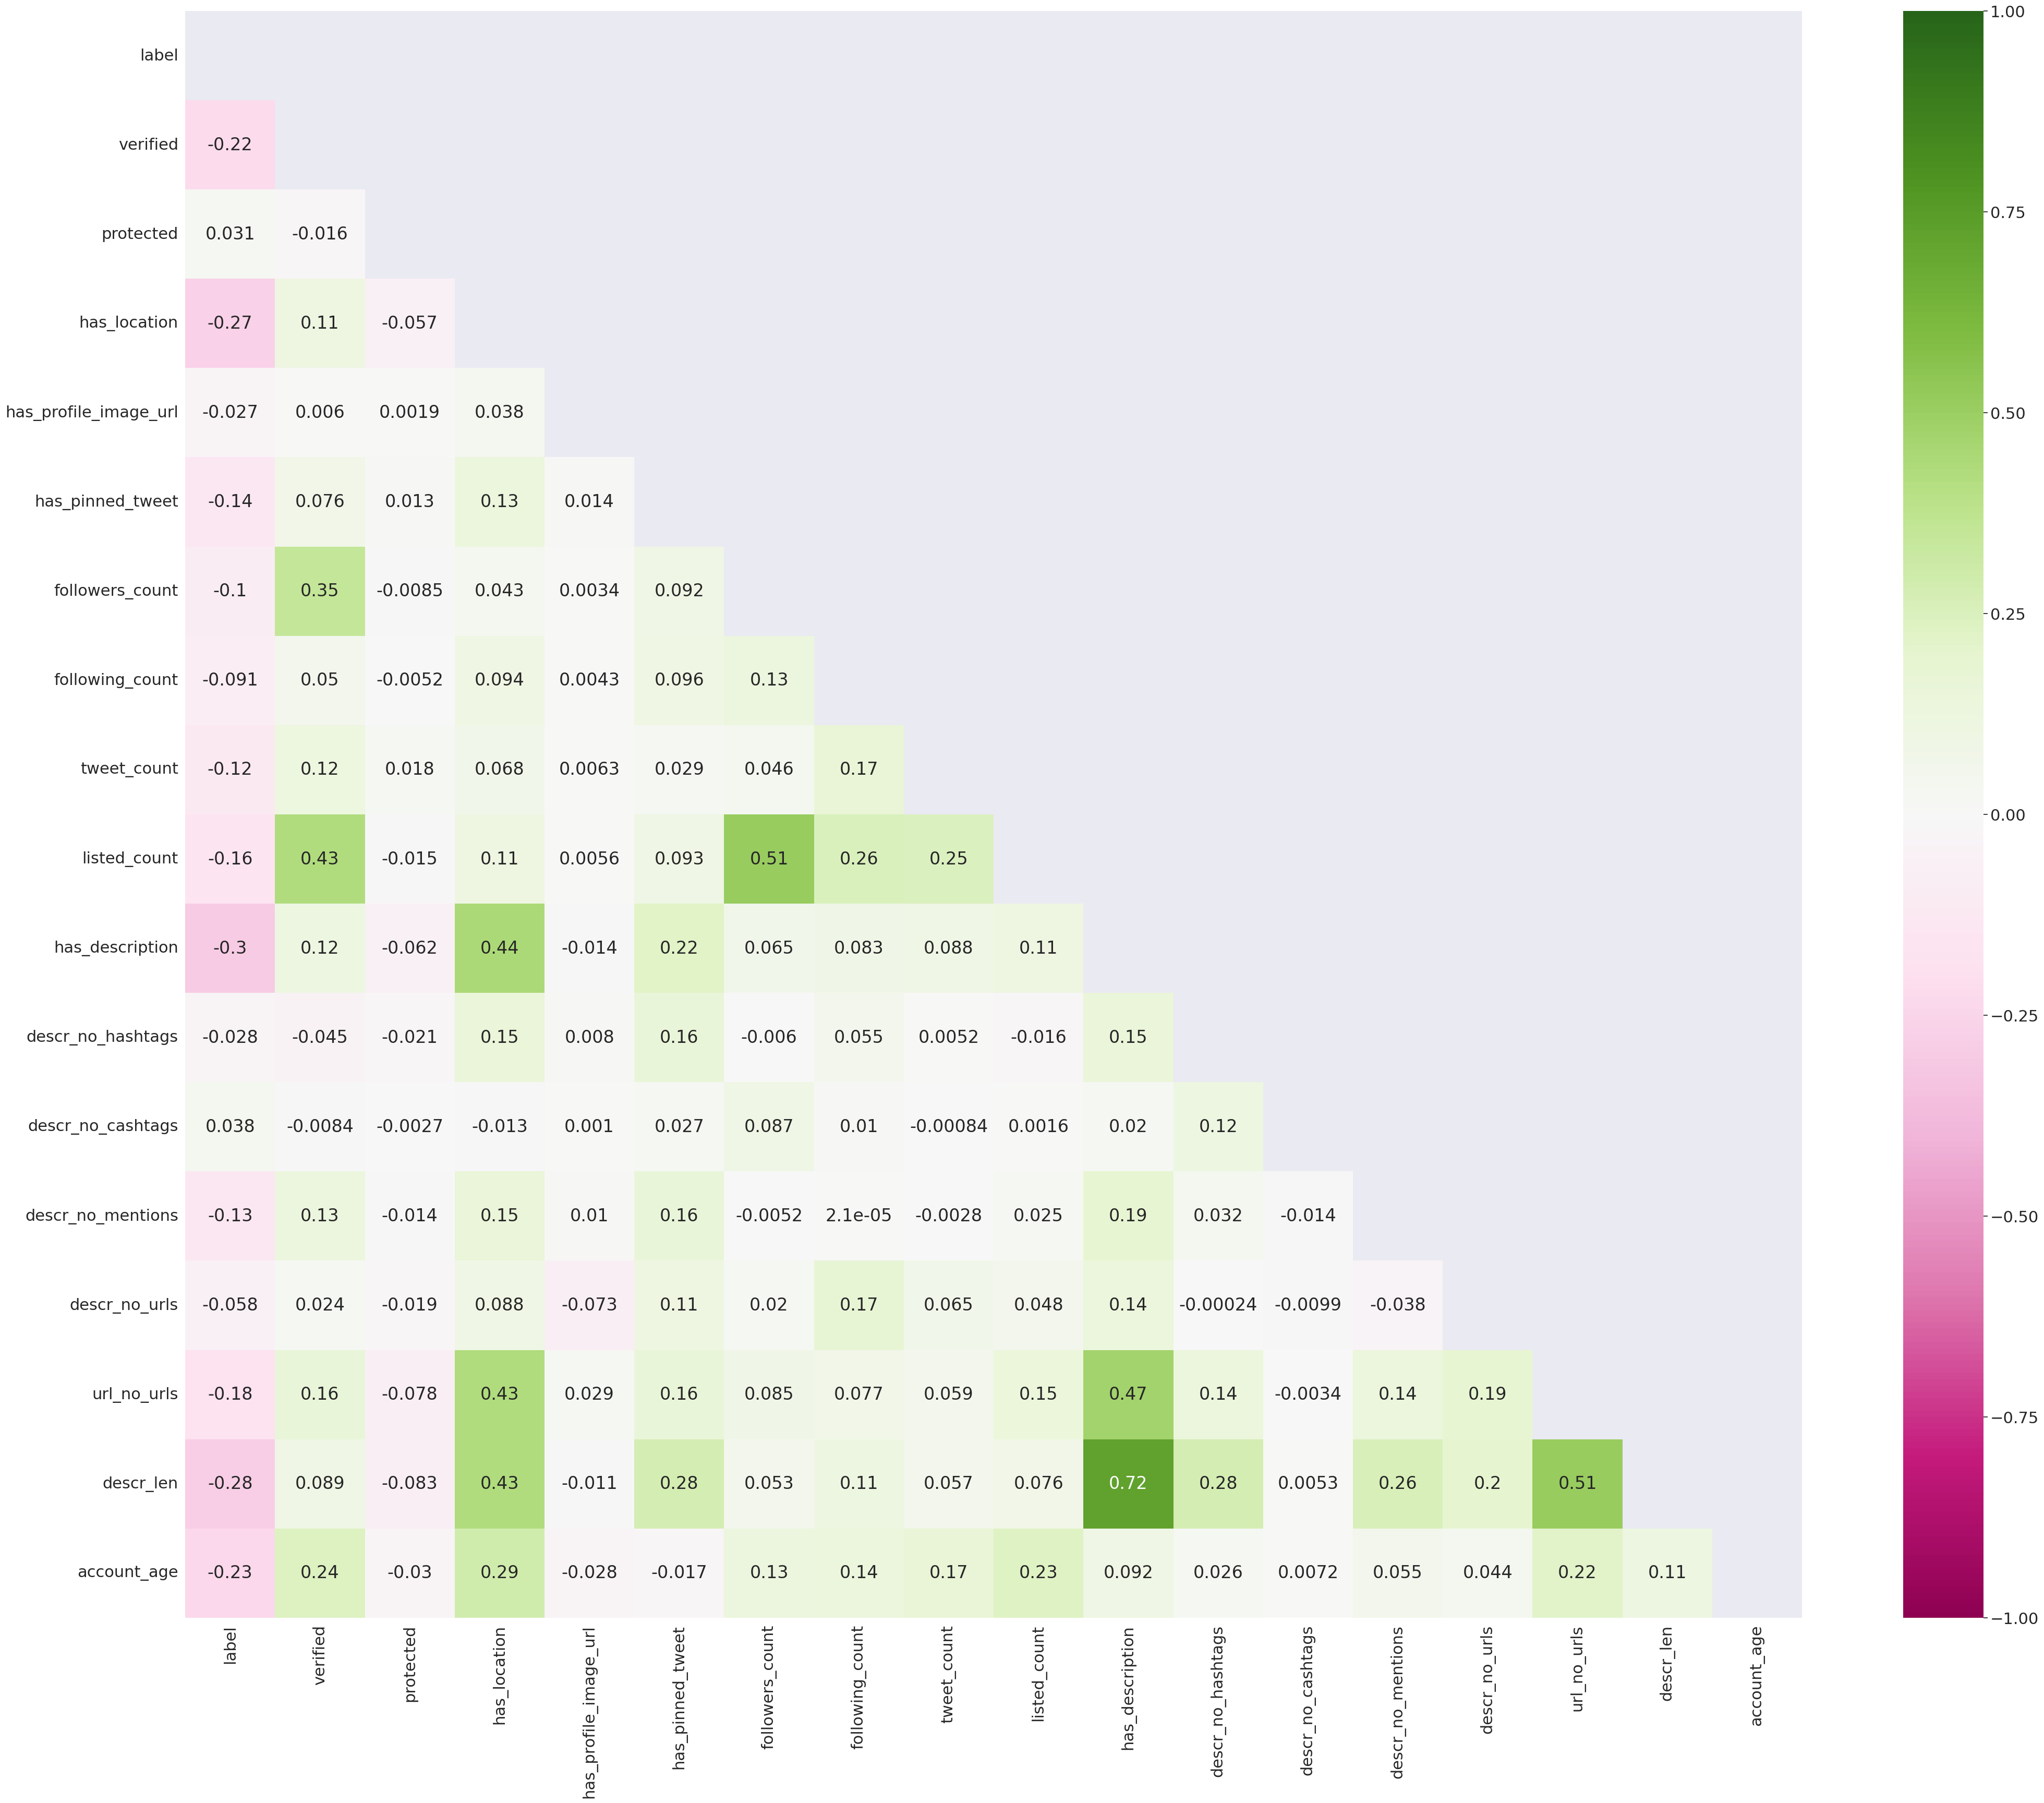

In [209]:
corr_threshold = 0.52
corr = train_data.corr()
lower_tri = corr.where(np.tril(np.ones(corr.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr = []
for column in train_data:
   for col in train_data:
     if abs(lower_tri[column][col]) > corr_threshold:
         high_corr.append((column, col, lower_tri[column][col]))
high_corr = sorted(high_corr, key=lambda x: x[2], reverse=True)

In [213]:
sns.set(font_scale=1)

In [215]:
print("Number of columns containing high correlation:", len(set([x[0] for x in high_corr])))
high_corr

Number of columns containing high correlation: 1


[('has_description', 'descr_len', 0.7243611817382376)]

In [216]:
train_data

label  verified  protected  has_location  has_profile_image_url  \
1718    1.0       0.0        0.0           1.0                    1.0   
1442    1.0       0.0        0.0           1.0                    1.0   
1404    1.0       0.0        0.0           1.0                    1.0   
1144    1.0       0.0        0.0           0.0                    1.0   
1218    1.0       0.0        0.0           1.0                    1.0   
...     ...       ...        ...           ...                    ...   
940     1.0       0.0        0.0           1.0                    1.0   
886     1.0       0.0        0.0           1.0                    1.0   
474     1.0       0.0        0.0           1.0                    1.0   
318     1.0       0.0        0.0           0.0                    1.0   
1156    1.0       0.0        0.0           0.0                    1.0   

      has_pinned_tweet  followers_count  following_count  tweet_count  \
1718               0.0             28.0            277.0        183.0   
1442               1.0            202.0             59.0       4661.0   
1404               0.0           1419.0            309.0       1210.0   
1144               0.0             43.0            258.0        440.0   
1218               1.0            457.0            128.0        213.0   
...                ...              ...              ...          ...   
940                1.0            372.0              1.0      13283.0   
886                0.0             55.0            218.0        350.0   
474                0.0           8708.0          10660.0        869.0   
318                0.0             12.0            117.0        670.0   
1156               0.0             65.0             74.0      12467.0   

      listed_count  has_description  descr_no_hashtags  descr_no_cashtags  \
1718           0.0              1.0                0.0                0.0   
1442           0.0              1.0                0.0                0.0   
1404          24.0              1.0                0.0                0.0   
1144           4.0              1.0                0.0                0.0   
1218           0.0              0.0                0.0                0.0   
...            ...              ...                ...                ...   
940            2.0              1.0                0.0                0.0   
886            0.0              1.0                3.0                0.0   
474          168.0              1.0                0.0                0.0   
318            0.0              1.0                0.0                0.0   
1156          54.0              0.0                0.0                0.0   

      descr_no_mentions  descr_no_urls  url_no_urls  descr_len  account_age  
1718                0.0            1.0          1.0      159.0        258.0  
1442                0.0            2.0          1.0      158.0       1567.0  
1404                0.0            0.0          1.0      101.0       4601.0  
1144                0.0            0.0          1.0      128.0       2708.0  
1218                0.0            0.0          0.0        0.0        622.0  
...                 ...            ...          ...        ...          ...  
940                 0.0            0.0          0.0      159.0        999.0  
886                 0.0            0.0          1.0       94.0         46.0  
474                 0.0            0.0          0.0      157.0       4716.0  
318                 0.0            0.0          1.0      118.0       3086.0  
1156                0.0            0.0          0.0        0.0       3232.0  

[1386 rows x 18 columns]

In [217]:
train_data = train_data.drop(['has_description'], axis=1)
val_data = val_data.drop(['has_description'], axis=1)
test_data = test_data.drop(['has_description'], axis=1)

### Correlation of data reduced by outliers

#### First drop columns in filter (without outliers) dataframe where now have same value in whole column

In [218]:
same_data_columns = list(train_data_wo_outliers.columns[train_data_wo_outliers.apply(lambda x: x.nunique()) == 1])
same_data_columns

['has_profile_image_url', 'descr_no_cashtags', 'descr_no_urls']

In [219]:
train_data_wo_outliers = train_data_wo_outliers.drop(same_data_columns, axis=1)

val_data_wo_outliers = val_data_wo_outliers.drop(same_data_columns, axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(same_data_columns, axis=1)

#### Correlation

In [220]:
sns.set(font_scale=2)

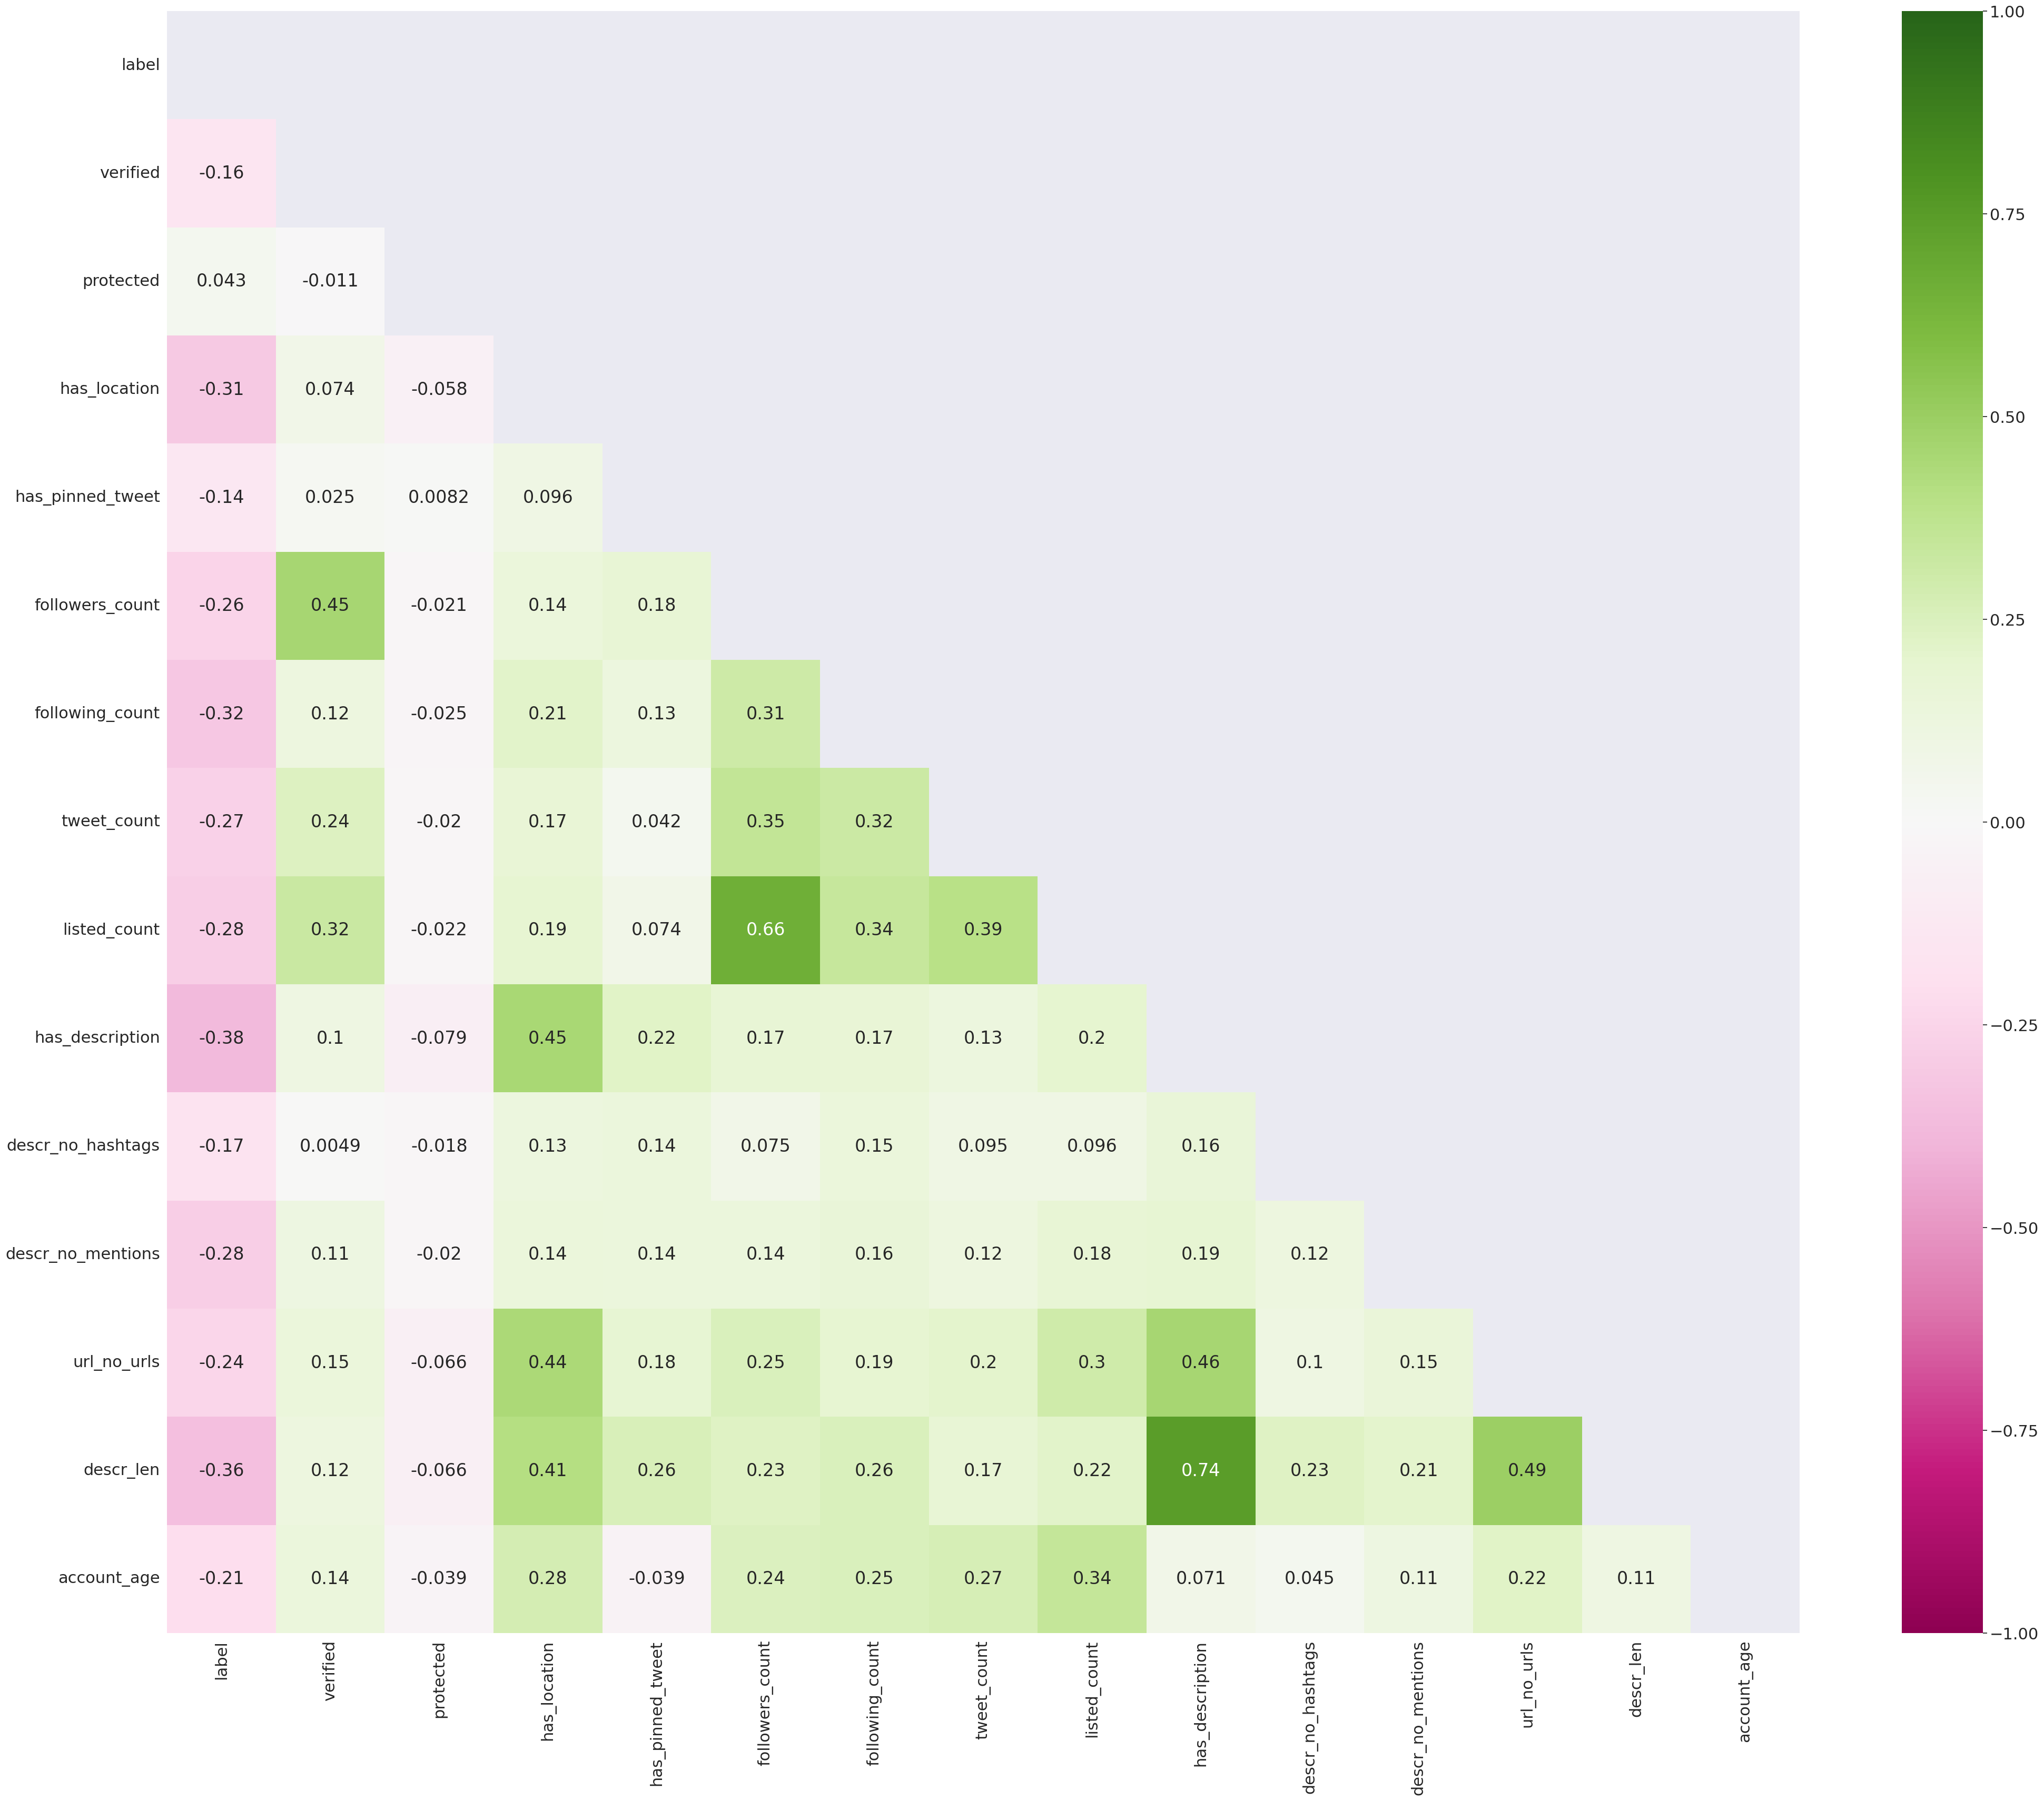

In [221]:
corr_threshold2 = 0.52
corr2 = train_data_wo_outliers.corr()
lower_tri2 = corr2.where(np.tril(np.ones(corr2.shape),k=-1).astype(bool)) #creating lower triangular correlation matrix
f = plt.figure(figsize=(50, 40))
sns.heatmap(lower_tri2, cmap="PiYG", annot=True, vmin=-1, vmax=1, ax=plt.gca()) #, annot_kws={"fontsize": 16})
high_corr2 = []
for column in train_data_wo_outliers:
   for col in train_data_wo_outliers:
     if abs(lower_tri2[column][col]) > corr_threshold2:
         high_corr2.append((column, col, lower_tri2[column][col]))
high_corr2 = sorted(high_corr2, key=lambda x: x[2], reverse=True)

#### Drop column with higher correlation

In [222]:
f = plt.figure(figsize=(50, 40))
sns.set(font_scale=1)

<Figure size 5000x4000 with 0 Axes>

In [223]:
high_corr2

[('has_description', 'descr_len', 0.7435354386188),
 ('followers_count', 'listed_count', 0.6568867834097464)]

In [224]:
train_data_wo_outliers = train_data_wo_outliers.drop(['listed_count', 'has_description'], axis=1)
val_data_wo_outliers = val_data_wo_outliers.drop(['listed_count', 'has_description'], axis=1)
test_data_wo_outliers = test_data_wo_outliers.drop(['listed_count', 'has_description'], axis=1)

#### Split data for input and output

In [225]:
train_X = train_data.drop(['label'], axis=1)
train_Y = pd.concat([train_data['label']], axis=1)
val_X = val_data.drop(['label'], axis=1)
val_Y = pd.concat([val_data['label']], axis=1)
test_X = test_data.drop(['label'], axis=1)
test_Y = pd.concat([test_data['label']], axis=1)


train_data_wo_outliers_X = train_data_wo_outliers.drop(['label'], axis=1)
train_data_wo_outliers_Y = pd.concat([train_data_wo_outliers['label']], axis=1)
val_data_wo_outliers_X = val_data_wo_outliers.drop(['label'], axis=1)
val_data_wo_outliers_Y = pd.concat([val_data_wo_outliers['label']], axis=1)
test_data_wo_outliers_X = test_data_wo_outliers.drop(['label'], axis=1)
test_data_wo_outliers_Y = pd.concat([test_data_wo_outliers['label']], axis=1)

# DNN models

#### Function to load a saved neural network model

In [226]:
from keras.models import load_model

def load_model_from_file(filepath):
  model = load_model(filepath)
  return model

#### Summary of metrics based on real and predicted data by the network

In [227]:
def get_model_metrics(test_Y, out_Y):
  accuracy = accuracy_score(test_Y, out_Y)
  print('Accuracy: {}'.format(accuracy))
  # precision tp / (tp + fp)
  precision = precision_score(test_Y, out_Y, average=None)
  print('Precision: {}'.format(precision))
  # recall: tp / (tp + fn)
  recall = recall_score(test_Y, out_Y)
  print('Recall: {}'.format(recall))
  # f1: 2 tp / (2 tp + fp + fn)
  f1 = f1_score(test_Y, out_Y)
  print('F1 score: %f' % f1)
  # ROC AUC
  auc = roc_auc_score(test_Y, out_Y)
  print('ROC AUC: %f' % auc)
  return (accuracy, precision, recall, f1, auc)

#### Creating a confusion matrix

In [228]:
def create_confusion_matrix(test_Y, out_Y):
    cm = sklearn.metrics.confusion_matrix(test_Y, out_Y)

    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    plt.figure()
    fig = plt.figure(figsize=(4,4))
    ax = fig.add_subplot(111)

    sns.heatmap(
        cm,
        annot=labels,
        annot_kws={"size": 12},
        fmt='',
        cmap=plt.cm.Blues,
        cbar=False
    )
    ax.set_title("Confusion matrix", fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=12)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=12)
    ax.set_ylabel('True', fontsize=12)
    ax.set_xlabel('Predicted', fontsize=12)
    
    fig.show()

## Neural network models 

In [229]:
# EarlyStopping
def early_stop(metric='val_accuracy', mode = 'max', patience=50):
    return EarlyStopping(monitor='val_accuracy',
                           patience=patience,
                           restore_best_weights=True,
                           mode=mode)
# PlotLosses
def plot_losses():
    return PlotLossesCallback()

# ModelCheckpoint
def checkpoint_callback(model_name):
    return ModelCheckpoint(filepath = models_path + '/' + model_name + '.hdf5',
                            monitor = "val_accuracy",
                            save_best_only = True,
                            # save_weights_only = True,
                            verbose=1)

In [230]:
def train_model(model, model_name, train_X, train_Y, val_X, val_Y, batch_size, epochs):
    model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs,
                validation_data=(val_X, val_Y),
                callbacks=[plot_losses(),
                           early_stop(),
                           checkpoint_callback(model_name)])
    return model

## Model 1.

#### Create model

In [231]:
def create_model_1(shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001)):
  model = Sequential()
  model.add(Input(shape=shape)),
  model.add(Dense(32, activation='sigmoid'))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(0.2))
  model.add(Dense(64, activation='relu'))
  model.add(Dense(64, activation='sigmoid'))
  model.add(Dropout(0.3))
  model.add(Dense(1, activation='sigmoid'))
  model.compile(optimizer=optimizer, loss=keras.losses.BinaryCrossentropy(), metrics=['accuracy'])
  return model

2023-08-26 13:20:46.797972: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/usr/local/nvidia/lib64:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-26 13:20:46.814119: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-26 13:20:46.814222: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (f26d5ed6224d): /proc/driver/nvidia/version does not exist
2023-08-26 13:20:47.003775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical o

### batch_size=10, epochs=300

#### Create and train model

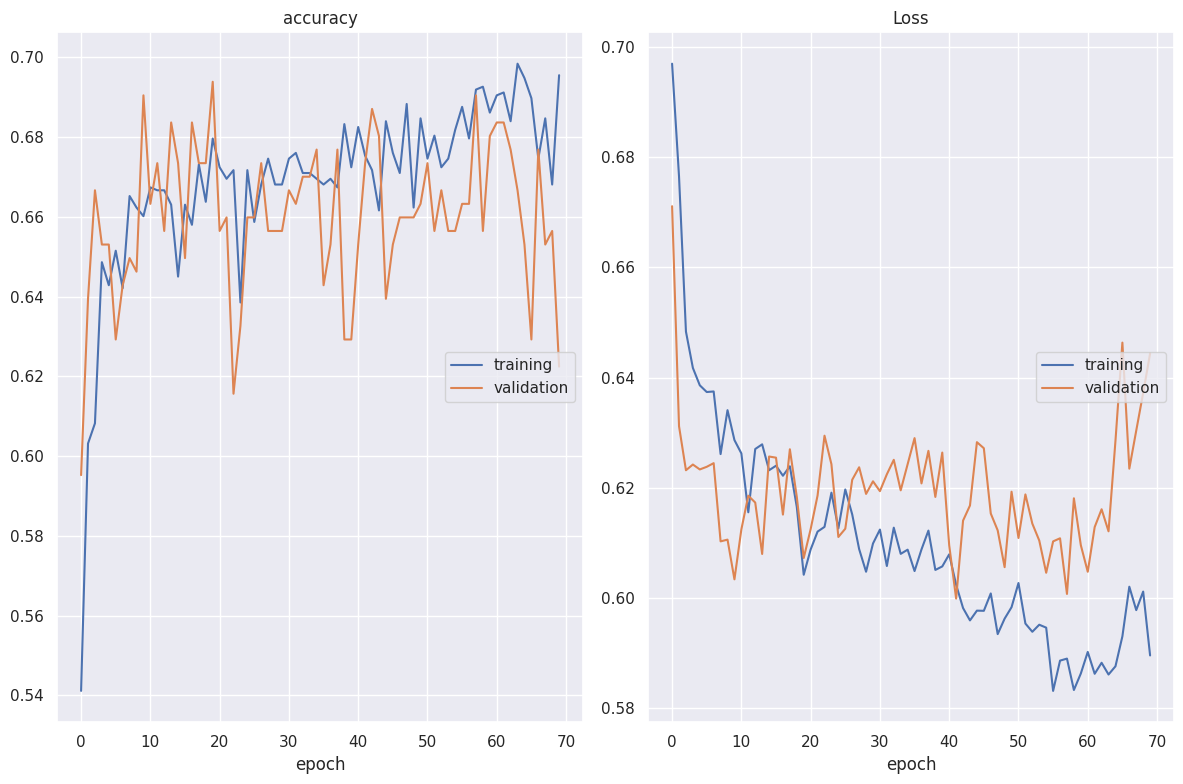

accuracy
	training         	 (min:    0.541, max:    0.698, cur:    0.696)
	validation       	 (min:    0.595, max:    0.694, cur:    0.622)
Loss
	training         	 (min:    0.583, max:    0.697, cur:    0.590)
	validation       	 (min:    0.600, max:    0.671, cur:    0.644)

Epoch 70: val_accuracy did not improve from 0.69388
139/139 [==============================] - 1s 7ms/step - loss: 0.5896 - accuracy: 0.6955 - val_loss: 0.6444 - val_accuracy: 0.6224


In [261]:
model_name = 'model_users_only_2000_1_v1_batch_size_10'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.6714285714285714
Precision: [0.70689655 0.64634146]
Recall: 0.7571428571428571
F1 score: 0.697368
ROC AUC: 0.671429


(0.6714285714285714,
 array([0.70689655, 0.64634146]),
 0.7571428571428571,
 0.6973684210526315,
 0.6714285714285713)

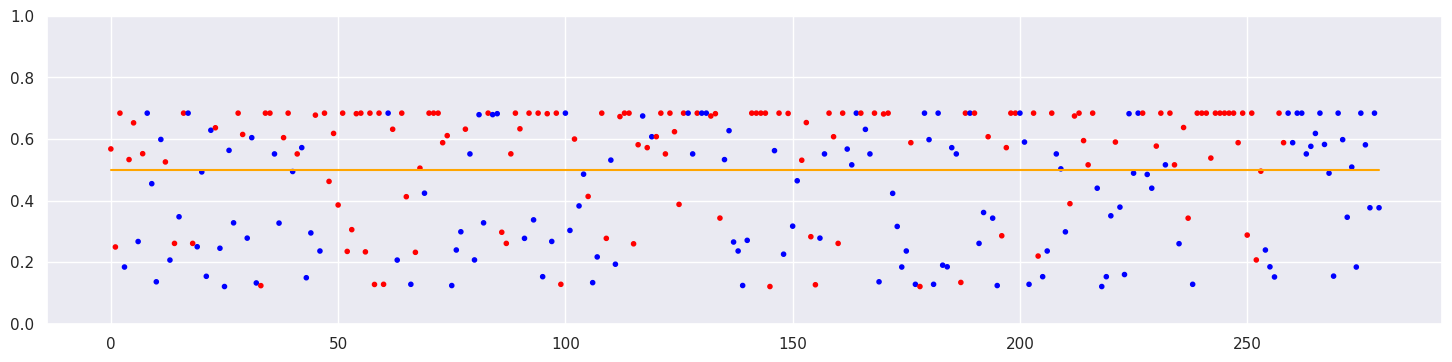

<Figure size 640x480 with 0 Axes>

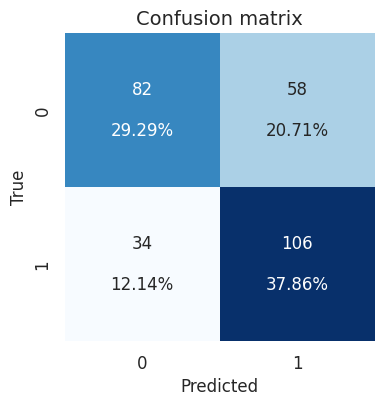

In [262]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=50, epochs=300

In [235]:
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
print(model1_v1.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 32)                544       
                                                                 
 dense_11 (Dense)            (None, 32)                1056      
                                                                 
 dropout_4 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 64)                2112      
                                                                 
 dense_13 (Dense)            (None, 64)                4160      
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                

### Train model

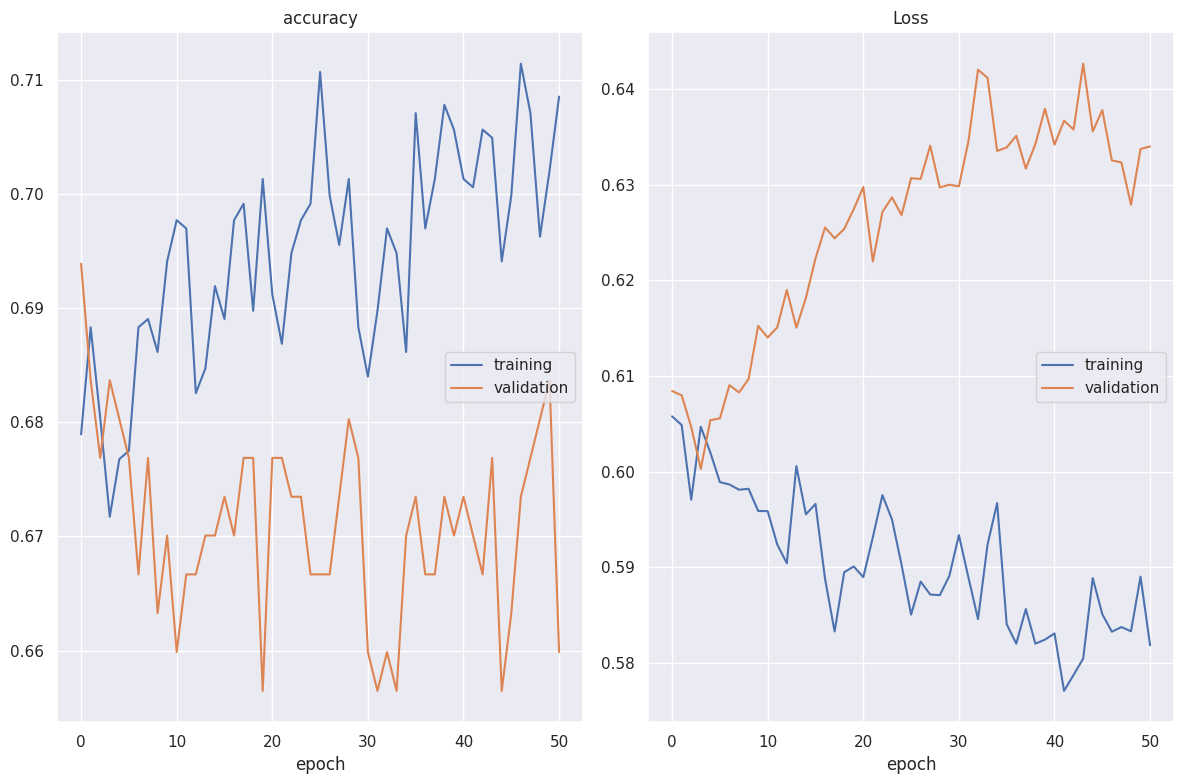

accuracy
	training         	 (min:    0.672, max:    0.711, cur:    0.709)
	validation       	 (min:    0.656, max:    0.694, cur:    0.660)
Loss
	training         	 (min:    0.577, max:    0.606, cur:    0.582)
	validation       	 (min:    0.600, max:    0.643, cur:    0.634)

Epoch 51: val_accuracy did not improve from 0.69388
28/28 [==============================] - 1s 24ms/step - loss: 0.5818 - accuracy: 0.7085 - val_loss: 0.6340 - val_accuracy: 0.6599


In [263]:
model_name = 'model_users_only_2000_1_v1_batch_size_50'
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=50, epochs=300)

In [264]:
# Load model
# model = load_model_from_file(models_path + '/model_name.hdf5')

#### Prediction

In [265]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

#### Results

(0.0, 1.0)

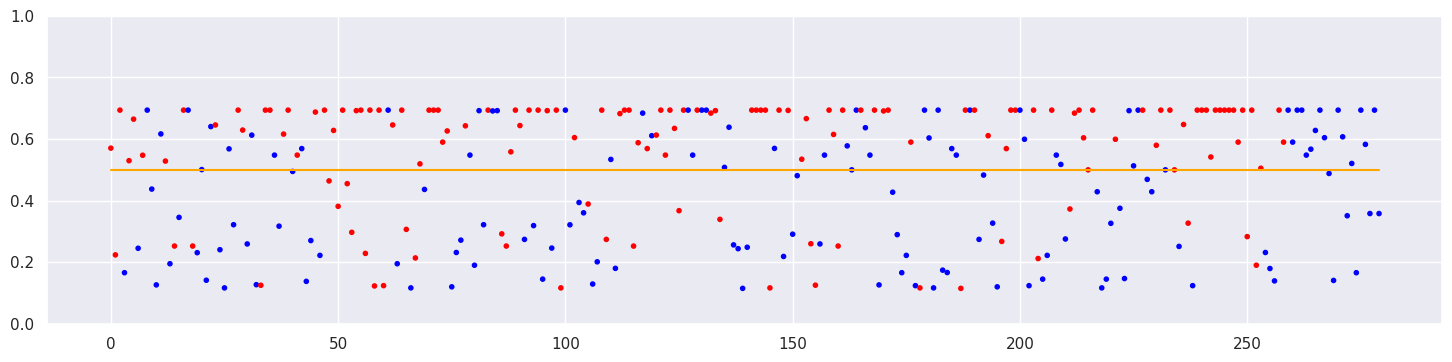

In [266]:
x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

#### Confusion matrix

Accuracy: 0.6678571428571428
Precision: [0.7008547  0.64417178]
Recall: 0.75
F1 score: 0.693069
ROC AUC: 0.667857


(0.6678571428571428,
 array([0.7008547 , 0.64417178]),
 0.75,
 0.6930693069306931,
 0.6678571428571428)

<Figure size 640x480 with 0 Axes>

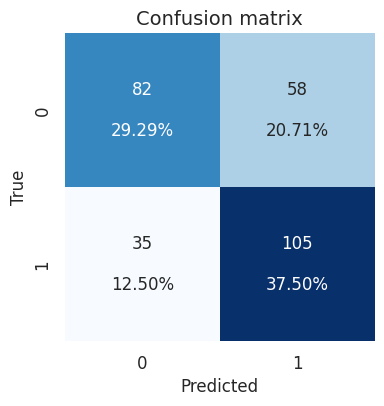

In [267]:
create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=100, epochs=300

#### Create and train model

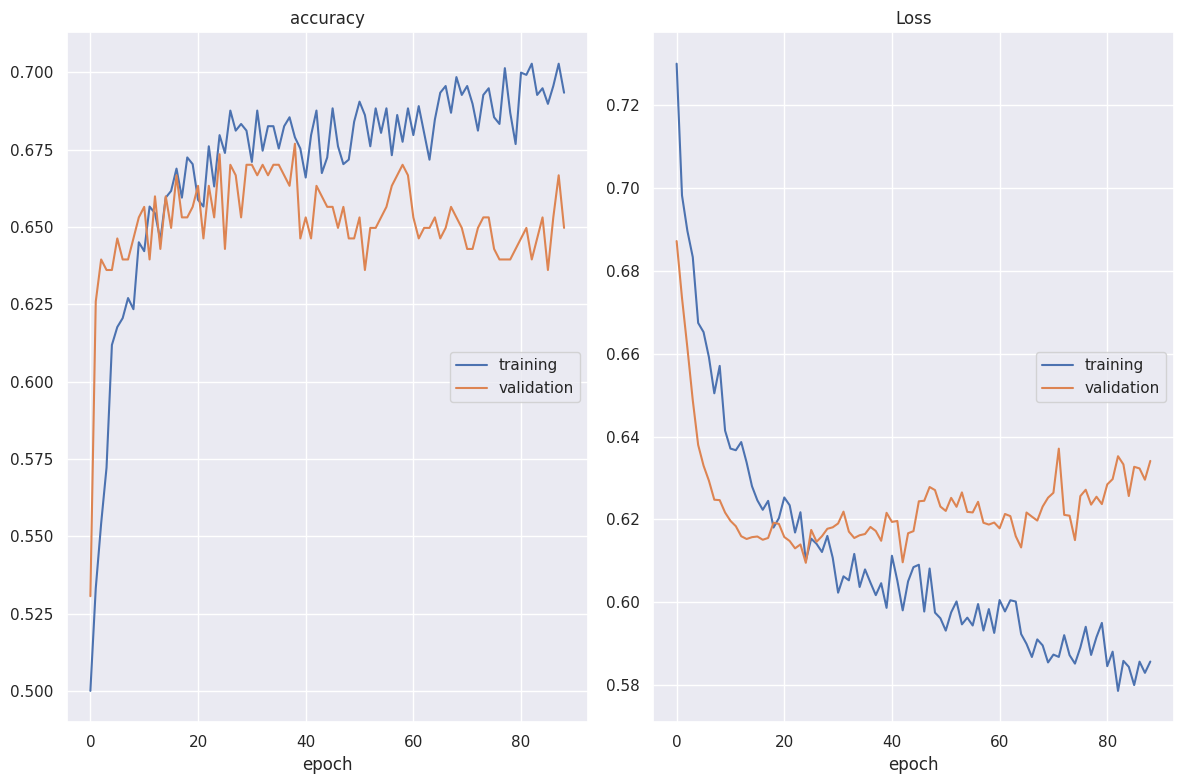

accuracy
	training         	 (min:    0.500, max:    0.703, cur:    0.693)
	validation       	 (min:    0.531, max:    0.677, cur:    0.650)
Loss
	training         	 (min:    0.579, max:    0.730, cur:    0.586)
	validation       	 (min:    0.610, max:    0.687, cur:    0.634)

Epoch 89: val_accuracy did not improve from 0.67687
14/14 [==============================] - 1s 48ms/step - loss: 0.5857 - accuracy: 0.6934 - val_loss: 0.6341 - val_accuracy: 0.6497


In [241]:
model_name = 'model_users_only_2000_1_v1_batch_size_100'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.6428571428571429
Precision: [0.67857143 0.61904762]
Recall: 0.7428571428571429
F1 score: 0.675325
ROC AUC: 0.642857


(0.6428571428571429,
 array([0.67857143, 0.61904762]),
 0.7428571428571429,
 0.6753246753246753,
 0.6428571428571429)

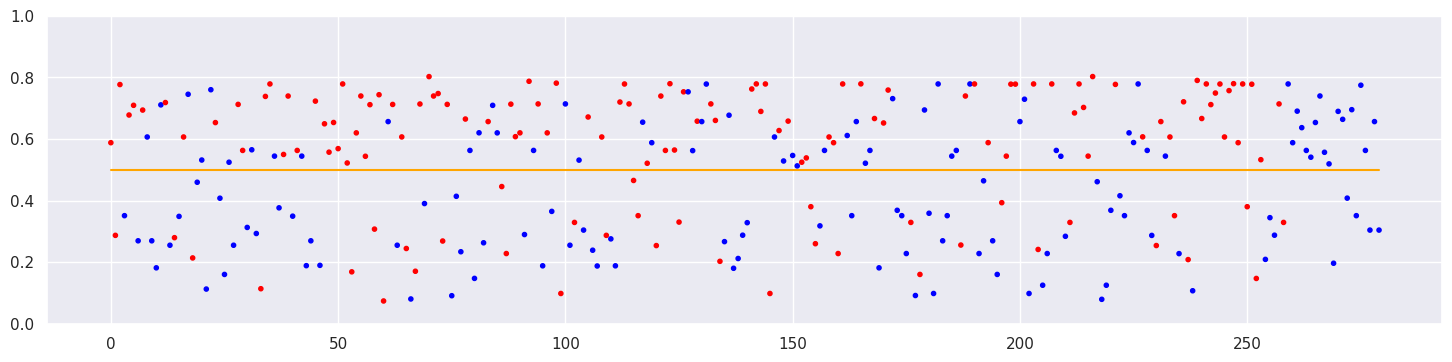

<Figure size 640x480 with 0 Axes>

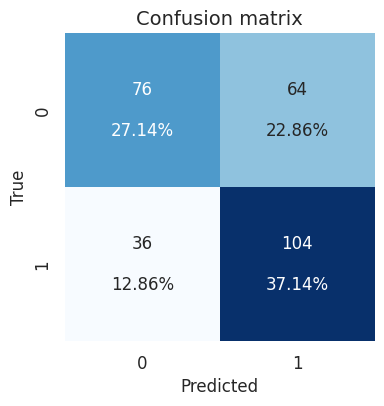

In [242]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=150, epochs=300

#### Create and train model

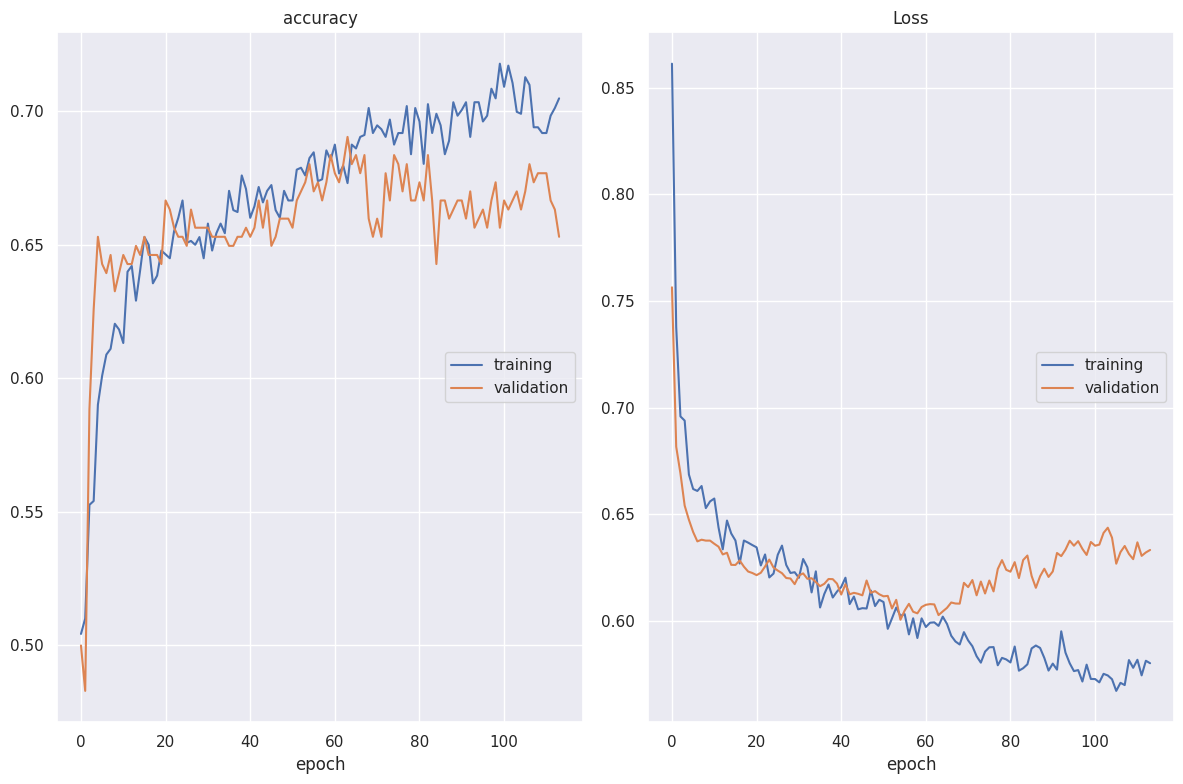

accuracy
	training         	 (min:    0.504, max:    0.718, cur:    0.705)
	validation       	 (min:    0.483, max:    0.690, cur:    0.653)
Loss
	training         	 (min:    0.567, max:    0.861, cur:    0.580)
	validation       	 (min:    0.601, max:    0.756, cur:    0.633)

Epoch 114: val_accuracy did not improve from 0.69048
10/10 [==============================] - 1s 65ms/step - loss: 0.5802 - accuracy: 0.7049 - val_loss: 0.6333 - val_accuracy: 0.6531


In [270]:
model_name = 'model_users_only_2000_1_v1_batch_size_150'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.6678571428571428
Precision: [0.68503937 0.65359477]
Recall: 0.7142857142857143
F1 score: 0.682594
ROC AUC: 0.667857


(0.6678571428571428,
 array([0.68503937, 0.65359477]),
 0.7142857142857143,
 0.6825938566552902,
 0.6678571428571429)

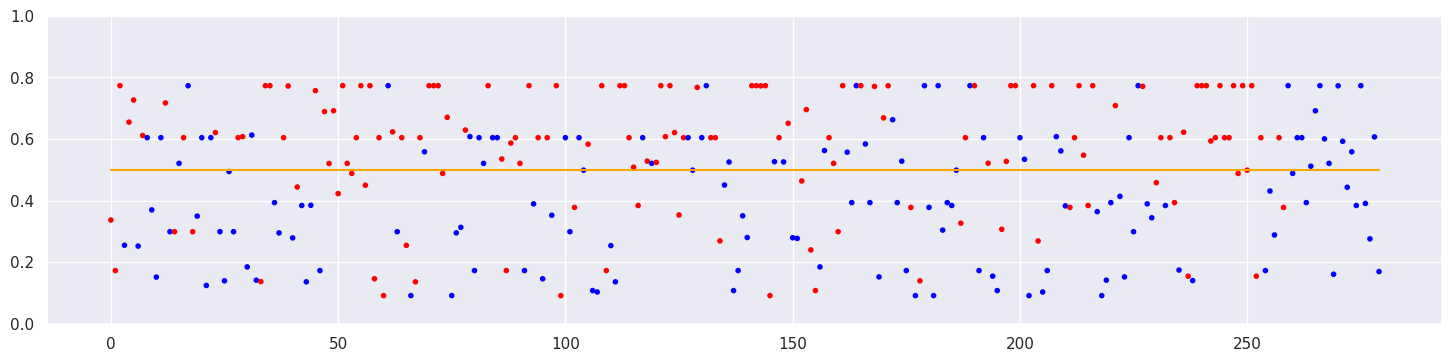

<Figure size 640x480 with 0 Axes>

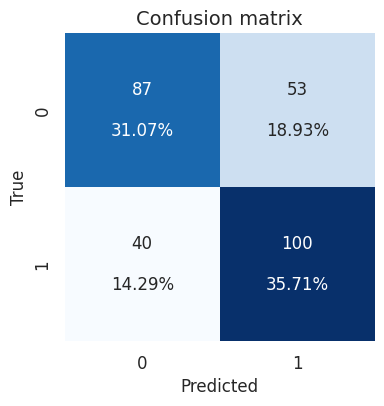

In [271]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=200, epochs=300

#### Create and train model

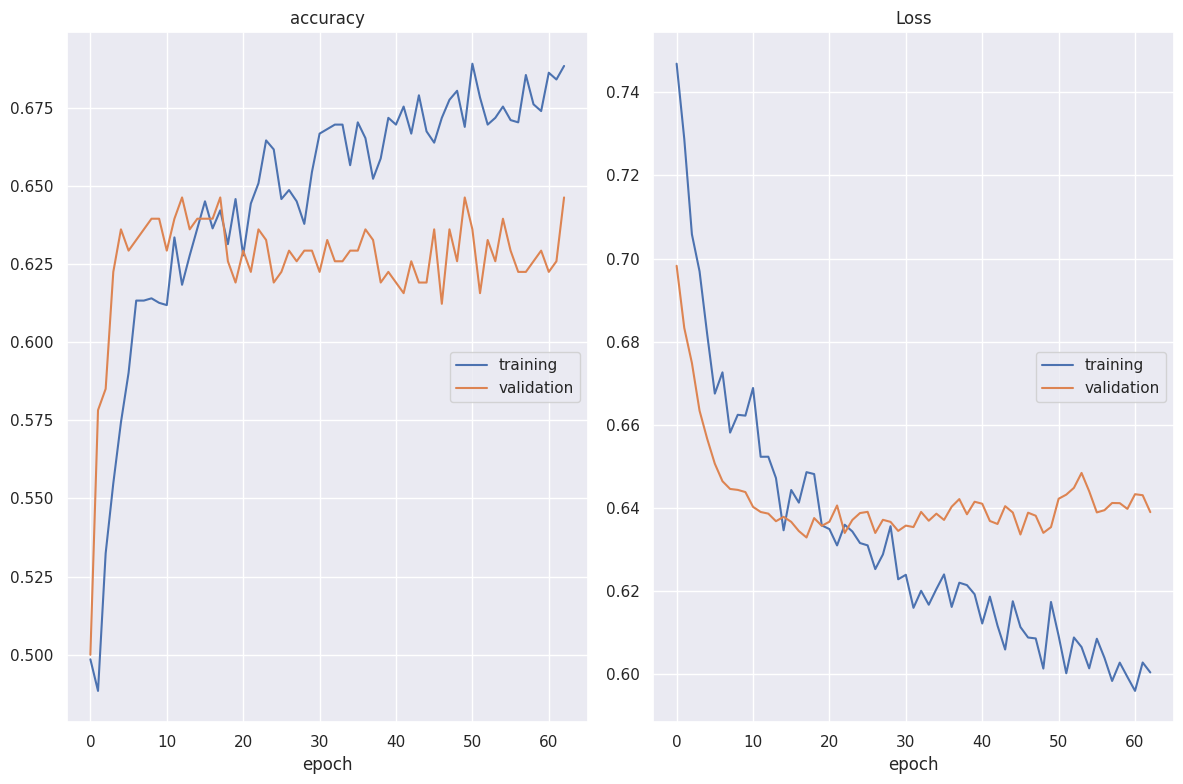

accuracy
	training         	 (min:    0.488, max:    0.689, cur:    0.688)
	validation       	 (min:    0.500, max:    0.646, cur:    0.646)
Loss
	training         	 (min:    0.596, max:    0.747, cur:    0.600)
	validation       	 (min:    0.633, max:    0.698, cur:    0.639)

Epoch 63: val_accuracy did not improve from 0.64626
7/7 [==============================] - 1s 111ms/step - loss: 0.6004 - accuracy: 0.6883 - val_loss: 0.6389 - val_accuracy: 0.6463


In [245]:
model_name = 'model_users_only_2000_1_v1_batch_size_200'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.6571428571428571
Precision: [0.64864865 0.66666667]
Recall: 0.6285714285714286
F1 score: 0.647059
ROC AUC: 0.657143


(0.6571428571428571,
 array([0.64864865, 0.66666667]),
 0.6285714285714286,
 0.6470588235294118,
 0.6571428571428571)

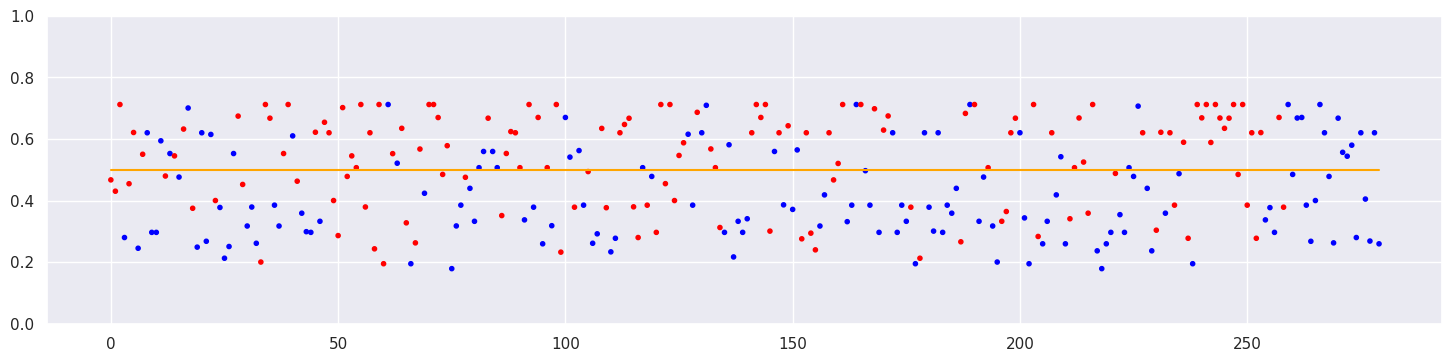

<Figure size 640x480 with 0 Axes>

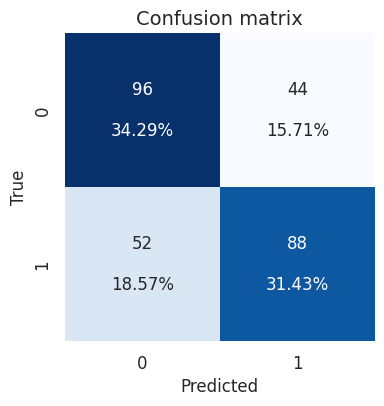

In [246]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### batch_size=250, epochs=300

#### Create and train model

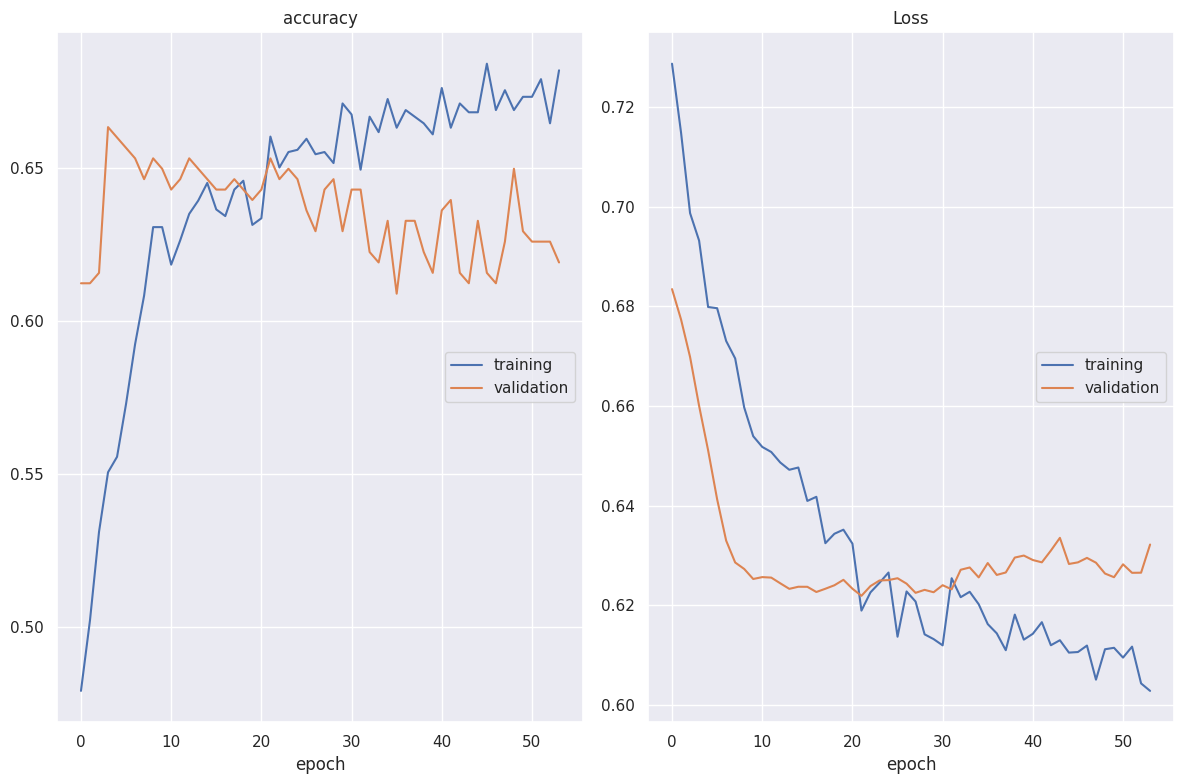

accuracy
	training         	 (min:    0.479, max:    0.684, cur:    0.682)
	validation       	 (min:    0.609, max:    0.663, cur:    0.619)
Loss
	training         	 (min:    0.603, max:    0.729, cur:    0.603)
	validation       	 (min:    0.622, max:    0.683, cur:    0.632)

Epoch 54: val_accuracy did not improve from 0.66327
6/6 [==============================] - 1s 128ms/step - loss: 0.6028 - accuracy: 0.6818 - val_loss: 0.6322 - val_accuracy: 0.6190


In [247]:
model_name = 'model_users_only_2000_1_v1_batch_size_250'
shape = (train_X.shape[1],)
model1_v1 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
model1_v1 = train_model(model1_v1, model_name, train_X, train_Y, val_X, val_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.6142857142857143
Precision: [0.63559322 0.59876543]
Recall: 0.6928571428571428
F1 score: 0.642384
ROC AUC: 0.614286


(0.6142857142857143,
 array([0.63559322, 0.59876543]),
 0.6928571428571428,
 0.6423841059602649,
 0.6142857142857143)

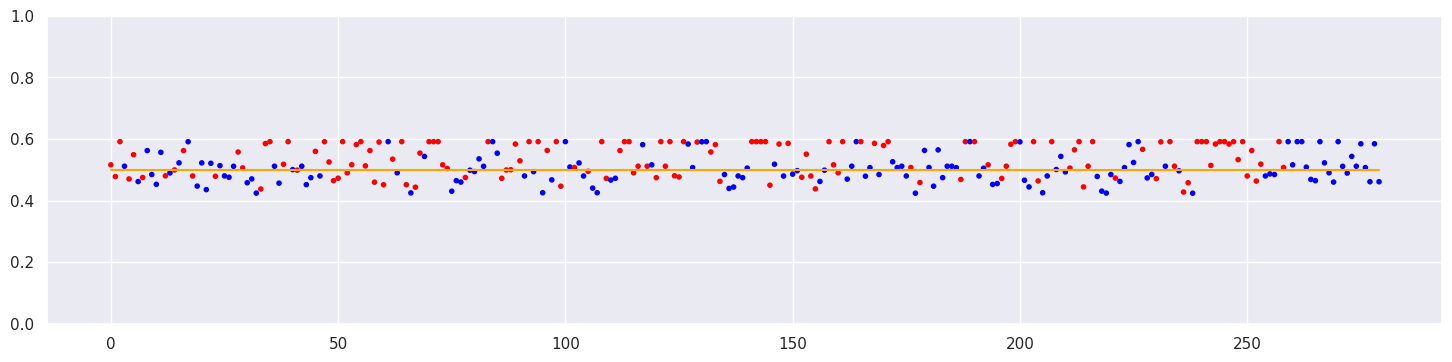

<Figure size 640x480 with 0 Axes>

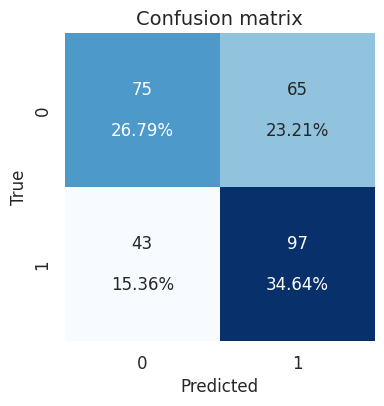

In [248]:
out_Y_org = model1_v1.predict(test_X, verbose=0)
out_Y = [0 if x < 0.5 else 1 for x in out_Y_org]

x = range(0, len(test_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_Y)]
plt.scatter(x, out_Y_org, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_Y, out_Y)
get_model_metrics(test_Y, out_Y)

### Model 1. - version for data reduced by outliers

### batch_size=10, epochs=300

#### Create and train model

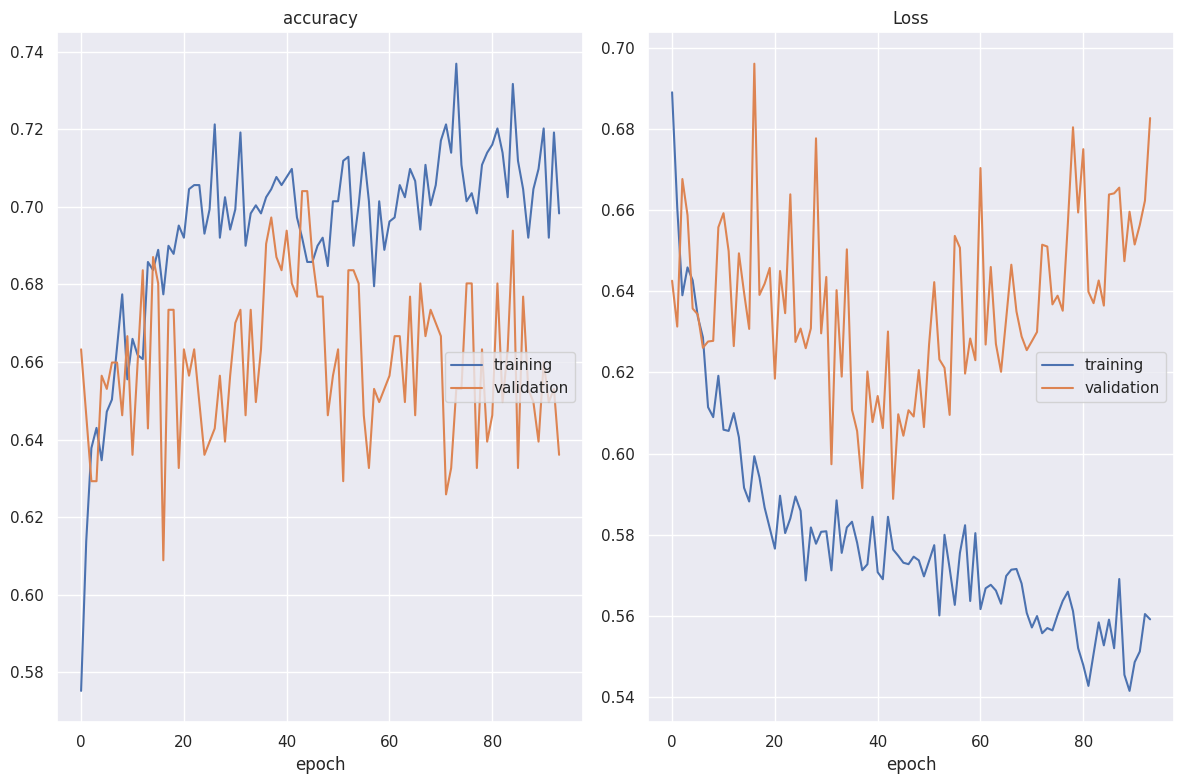

accuracy
	training         	 (min:    0.575, max:    0.737, cur:    0.698)
	validation       	 (min:    0.609, max:    0.704, cur:    0.636)
Loss
	training         	 (min:    0.541, max:    0.689, cur:    0.559)
	validation       	 (min:    0.589, max:    0.696, cur:    0.683)

Epoch 94: val_accuracy did not improve from 0.70408
96/96 [==============================] - 1s 9ms/step - loss: 0.5591 - accuracy: 0.6983 - val_loss: 0.6828 - val_accuracy: 0.6361


In [272]:
model_name = 'model_users_only_2000_1_v2_wo_outliers_batch_size_10'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=10, epochs=300)

#### Prediction and results

Accuracy: 0.675
Precision: [0.67132867 0.67883212]
Recall: 0.6642857142857143
F1 score: 0.671480
ROC AUC: 0.675000


(0.675,
 array([0.67132867, 0.67883212]),
 0.6642857142857143,
 0.6714801444043321,
 0.6749999999999999)

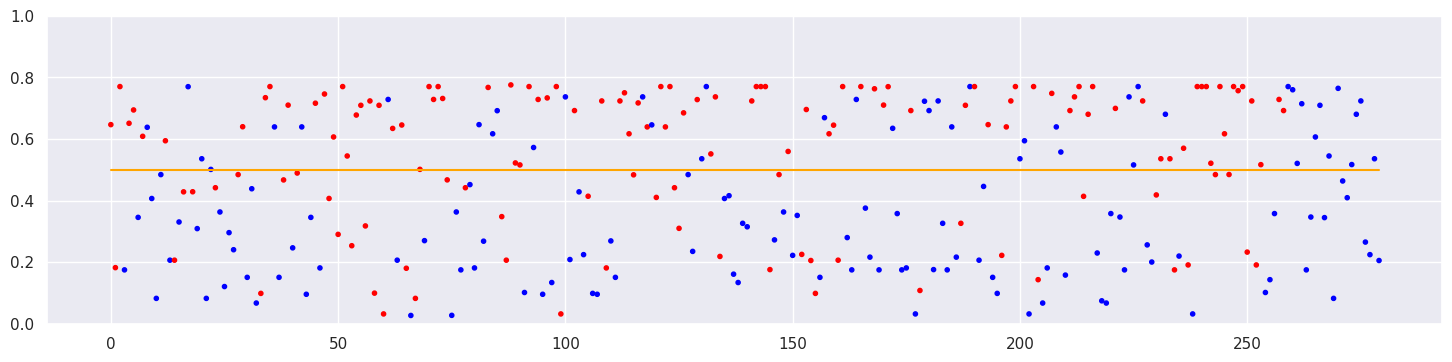

<Figure size 640x480 with 0 Axes>

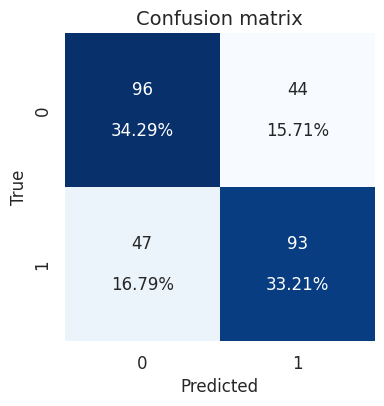

In [273]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=50, epochs=300

#### Create and train model

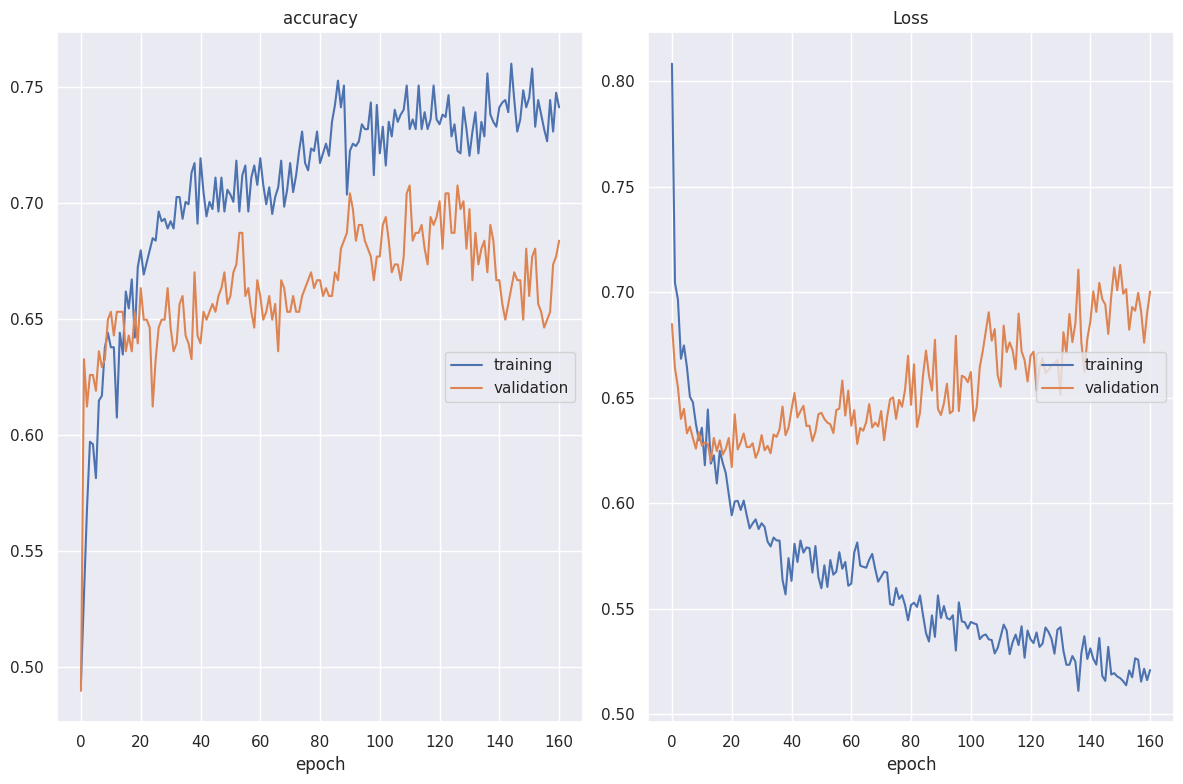

accuracy
	training         	 (min:    0.494, max:    0.760, cur:    0.741)
	validation       	 (min:    0.490, max:    0.707, cur:    0.684)
Loss
	training         	 (min:    0.511, max:    0.808, cur:    0.521)
	validation       	 (min:    0.617, max:    0.713, cur:    0.700)

Epoch 161: val_accuracy did not improve from 0.70748
20/20 [==============================] - 1s 35ms/step - loss: 0.5209 - accuracy: 0.7411 - val_loss: 0.7004 - val_accuracy: 0.6837


In [278]:
model_name = 'model_users_only_2000_1_v2_wo_outliers_batch_size_50'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=50, epochs=300)

#### Prediction and results

Accuracy: 0.6678571428571428
Precision: [0.66666667 0.66906475]
Recall: 0.6642857142857143
F1 score: 0.666667
ROC AUC: 0.667857


(0.6678571428571428,
 array([0.66666667, 0.66906475]),
 0.6642857142857143,
 0.6666666666666666,
 0.6678571428571428)

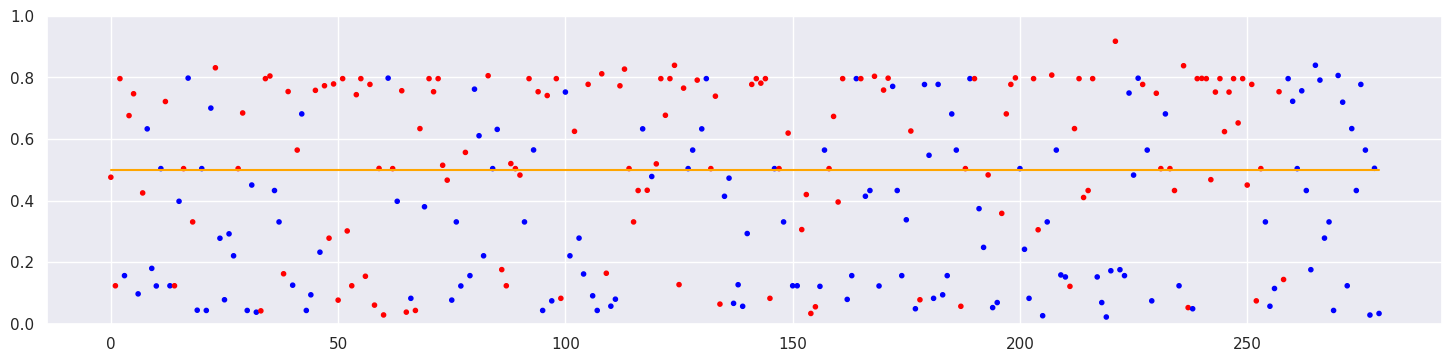

<Figure size 640x480 with 0 Axes>

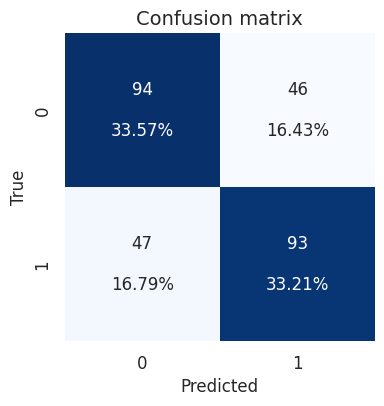

In [279]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=100, epochs=300

#### Create and train model

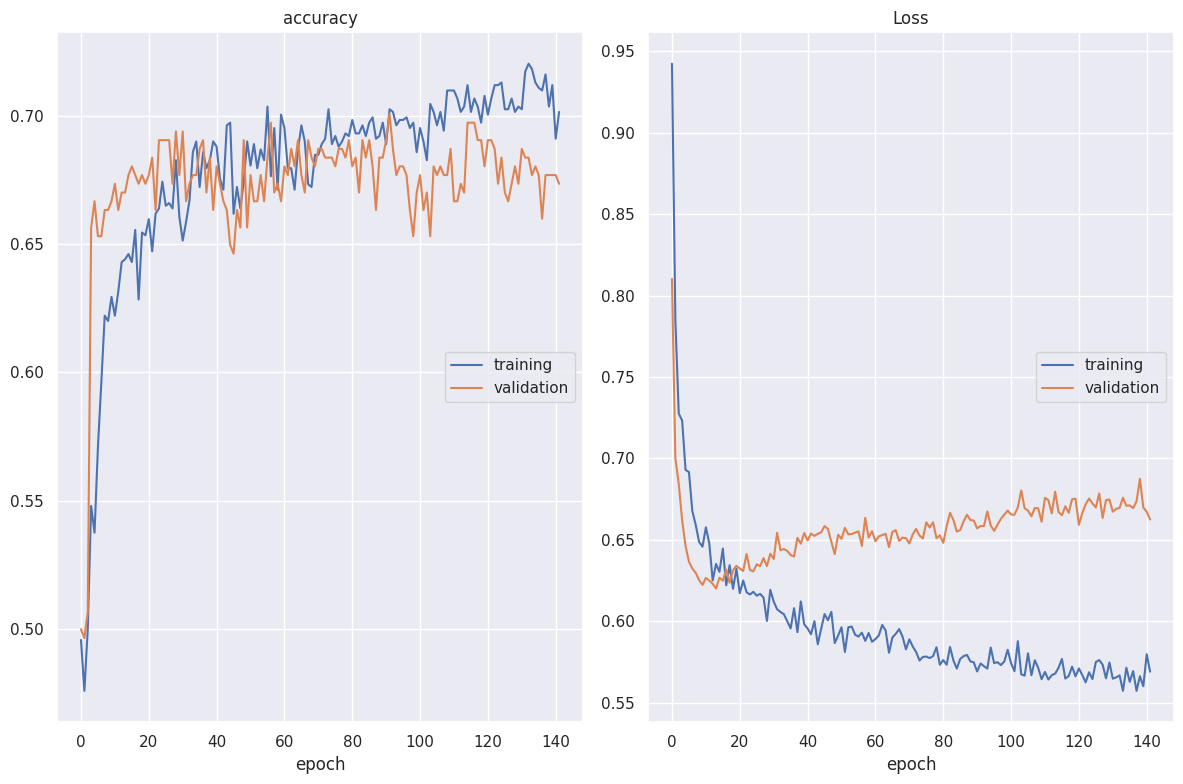

accuracy
	training         	 (min:    0.476, max:    0.720, cur:    0.701)
	validation       	 (min:    0.497, max:    0.701, cur:    0.673)
Loss
	training         	 (min:    0.557, max:    0.942, cur:    0.569)
	validation       	 (min:    0.620, max:    0.810, cur:    0.662)

Epoch 142: val_accuracy did not improve from 0.70068
10/10 [==============================] - 1s 71ms/step - loss: 0.5690 - accuracy: 0.7015 - val_loss: 0.6625 - val_accuracy: 0.6735


In [280]:
model_name = 'model_users_only_2000_1_v2_wo_outliers_batch_size_100'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=100, epochs=300)

#### Prediction and results

Accuracy: 0.6321428571428571
Precision: [0.648      0.61935484]
Recall: 0.6857142857142857
F1 score: 0.650847
ROC AUC: 0.632143


(0.6321428571428571,
 array([0.648     , 0.61935484]),
 0.6857142857142857,
 0.6508474576271186,
 0.6321428571428571)

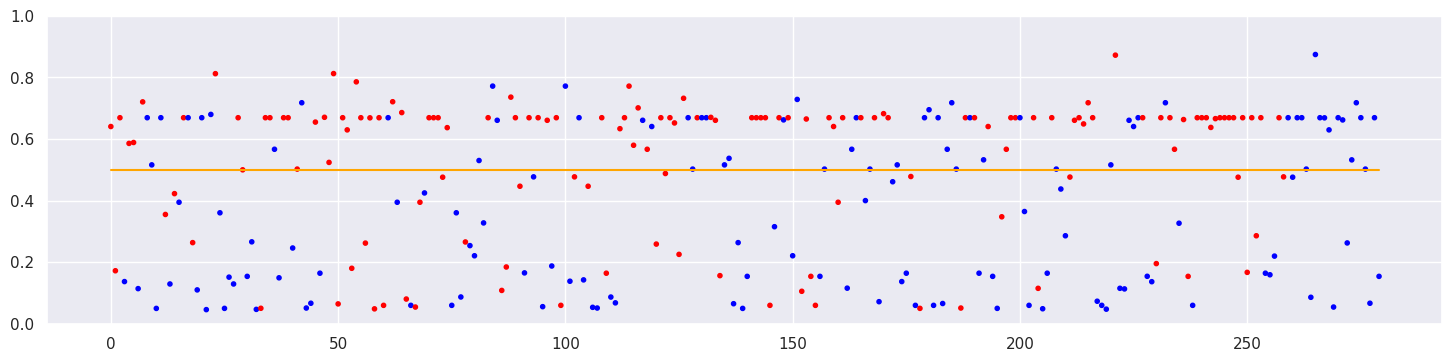

<Figure size 640x480 with 0 Axes>

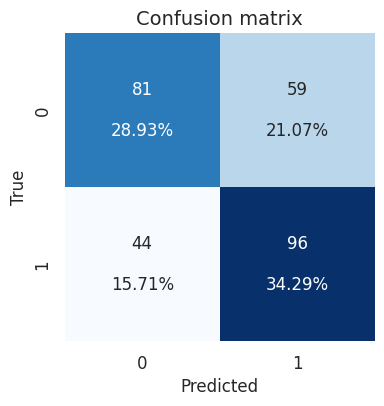

In [281]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=150, epochs=300

#### Create and train model

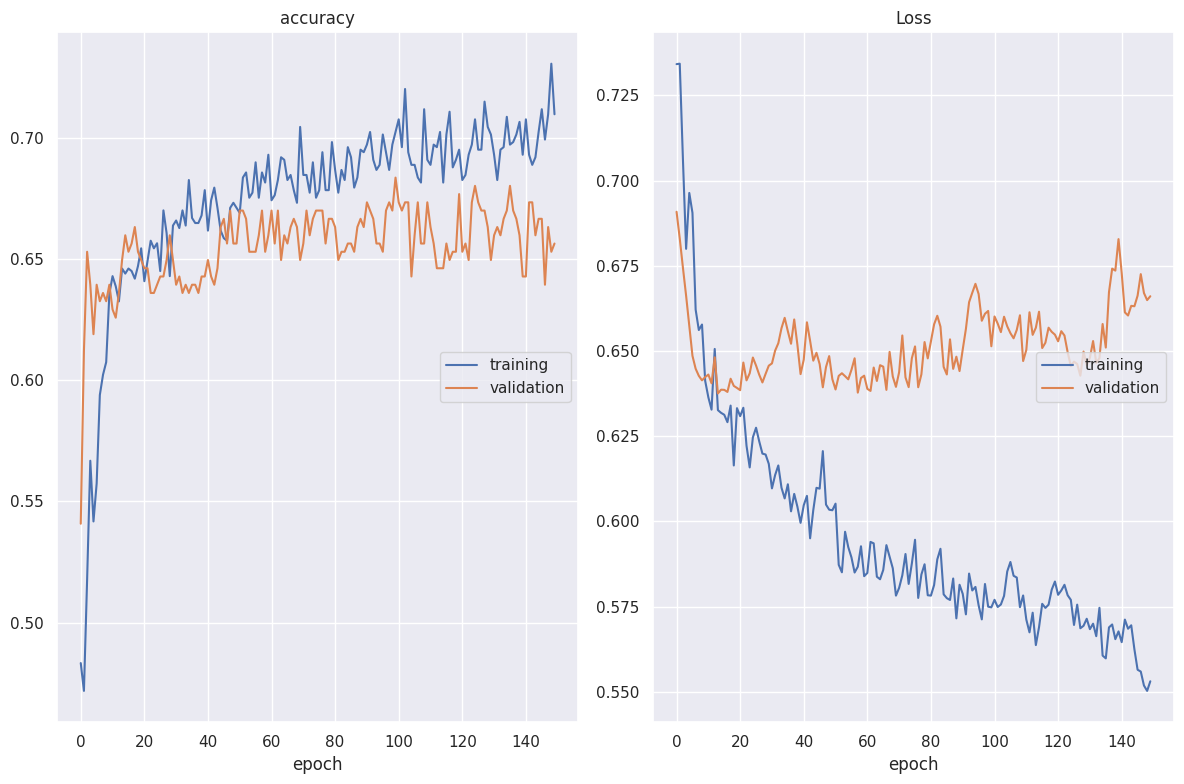

accuracy
	training         	 (min:    0.472, max:    0.731, cur:    0.710)
	validation       	 (min:    0.541, max:    0.684, cur:    0.656)
Loss
	training         	 (min:    0.550, max:    0.734, cur:    0.553)
	validation       	 (min:    0.638, max:    0.691, cur:    0.666)

Epoch 150: val_accuracy did not improve from 0.68367
7/7 [==============================] - 1s 107ms/step - loss: 0.5531 - accuracy: 0.7098 - val_loss: 0.6661 - val_accuracy: 0.6565


In [282]:
model_name = 'model_users_only_2000_1_v2_wo_outliers_batch_size_150'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=150, epochs=300)

#### Prediction and results

Accuracy: 0.6571428571428571
Precision: [0.68032787 0.63924051]
Recall: 0.7214285714285714
F1 score: 0.677852
ROC AUC: 0.657143


(0.6571428571428571,
 array([0.68032787, 0.63924051]),
 0.7214285714285714,
 0.6778523489932886,
 0.6571428571428571)

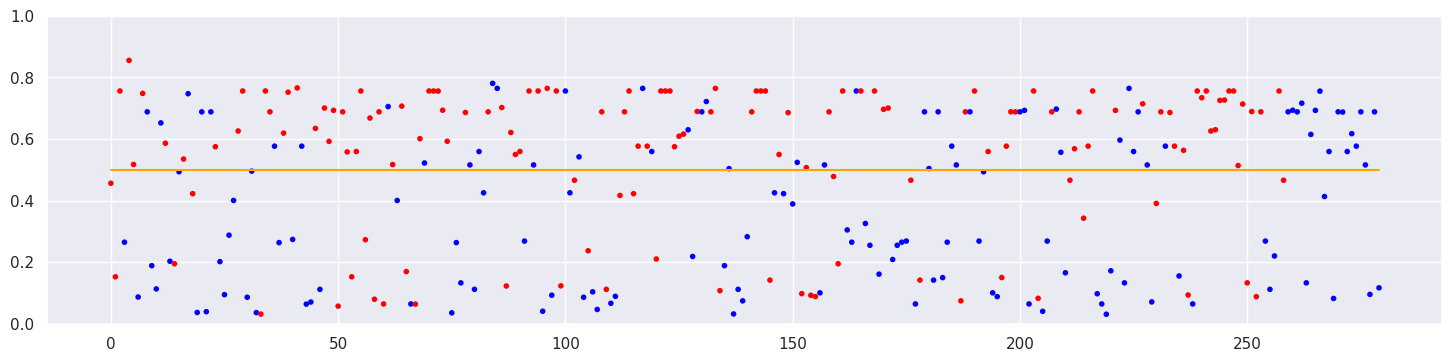

<Figure size 640x480 with 0 Axes>

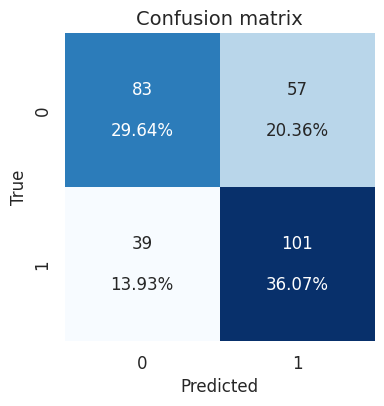

In [283]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=200, epochs=300

#### Create and train model

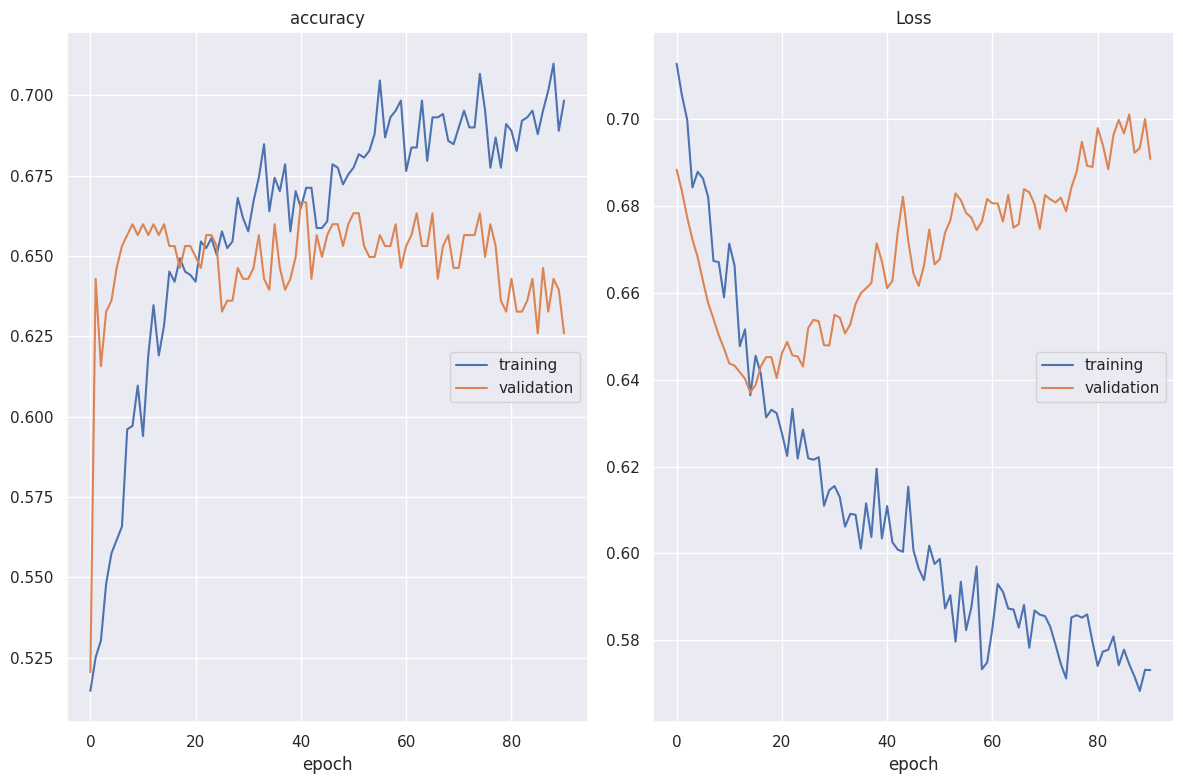

accuracy
	training         	 (min:    0.515, max:    0.710, cur:    0.698)
	validation       	 (min:    0.520, max:    0.667, cur:    0.626)
Loss
	training         	 (min:    0.568, max:    0.713, cur:    0.573)
	validation       	 (min:    0.637, max:    0.701, cur:    0.691)

Epoch 91: val_accuracy did not improve from 0.66667
5/5 [==============================] - 1s 151ms/step - loss: 0.5732 - accuracy: 0.6983 - val_loss: 0.6908 - val_accuracy: 0.6259


In [257]:
model_name = 'model_users_only_2000_1_v2_wo_outliers_batch_size_200'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=200, epochs=300)

#### Prediction and results

Accuracy: 0.6535714285714286
Precision: [0.65693431 0.65034965]
Recall: 0.6642857142857143
F1 score: 0.657244
ROC AUC: 0.653571


(0.6535714285714286,
 array([0.65693431, 0.65034965]),
 0.6642857142857143,
 0.657243816254417,
 0.6535714285714285)

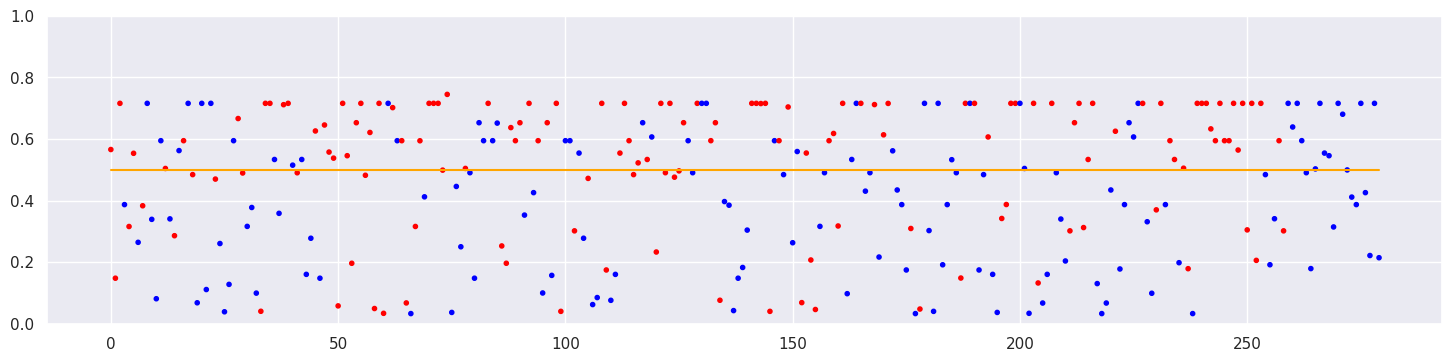

<Figure size 640x480 with 0 Axes>

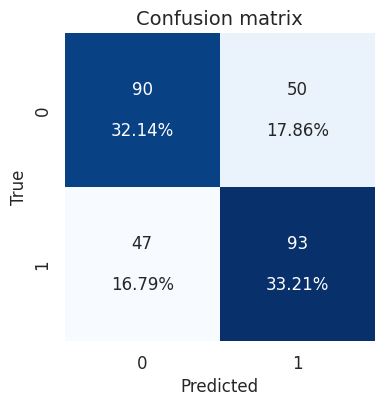

In [258]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)

### batch_size=250, epochs=300

#### Create and train model

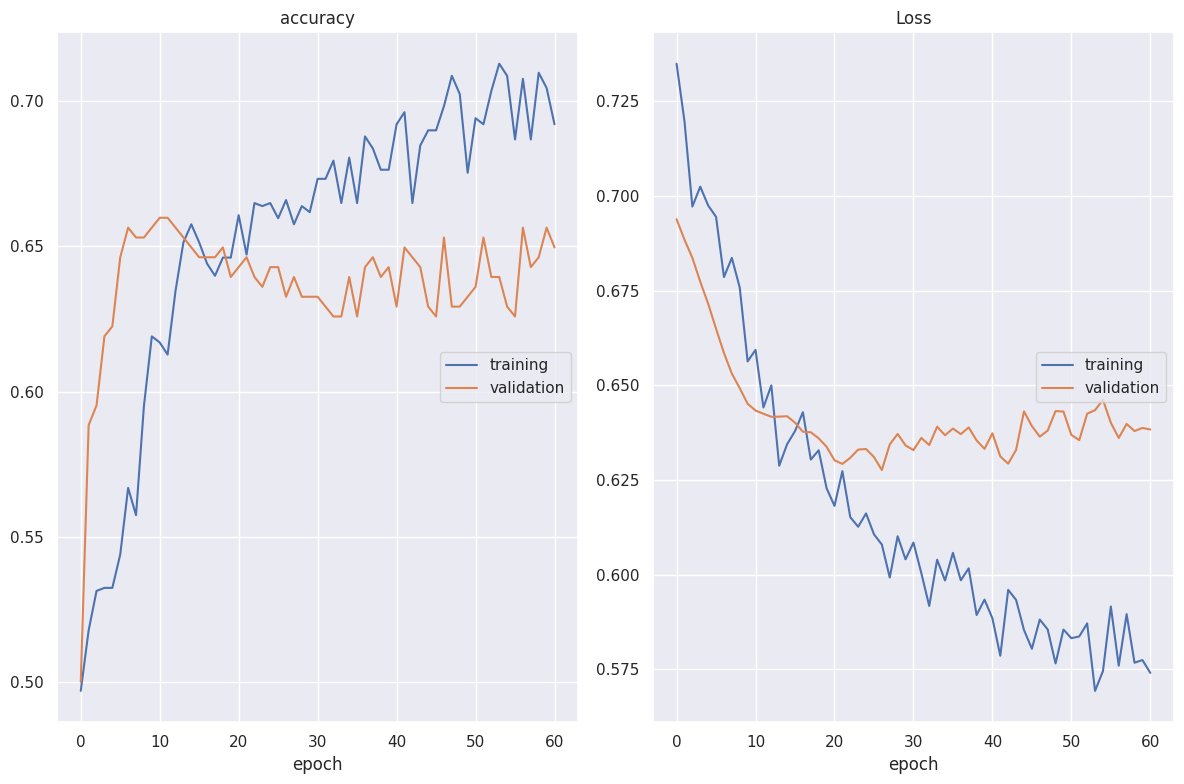

accuracy
	training         	 (min:    0.497, max:    0.713, cur:    0.692)
	validation       	 (min:    0.500, max:    0.660, cur:    0.650)
Loss
	training         	 (min:    0.569, max:    0.735, cur:    0.574)
	validation       	 (min:    0.628, max:    0.694, cur:    0.638)

Epoch 61: val_accuracy did not improve from 0.65986
4/4 [==============================] - 1s 205ms/step - loss: 0.5741 - accuracy: 0.6921 - val_loss: 0.6383 - val_accuracy: 0.6497


In [286]:
model_name = 'model_users_only_2000_1_v2_wo_outliers_batch_size_250'
shape = (train_data_wo_outliers_X.shape[1],)
model1_v2 = create_model_1(shape=shape, optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
# print(model.summary())
model1_v2 = train_model(model1_v2, model_name, train_data_wo_outliers_X, train_data_wo_outliers_Y, val_data_wo_outliers_X, val_data_wo_outliers_Y, batch_size=250, epochs=300)

#### Prediction and results

Accuracy: 0.6428571428571429
Precision: [0.61904762 0.67857143]
Recall: 0.5428571428571428
F1 score: 0.603175
ROC AUC: 0.642857


(0.6428571428571429,
 array([0.61904762, 0.67857143]),
 0.5428571428571428,
 0.603174603174603,
 0.6428571428571428)

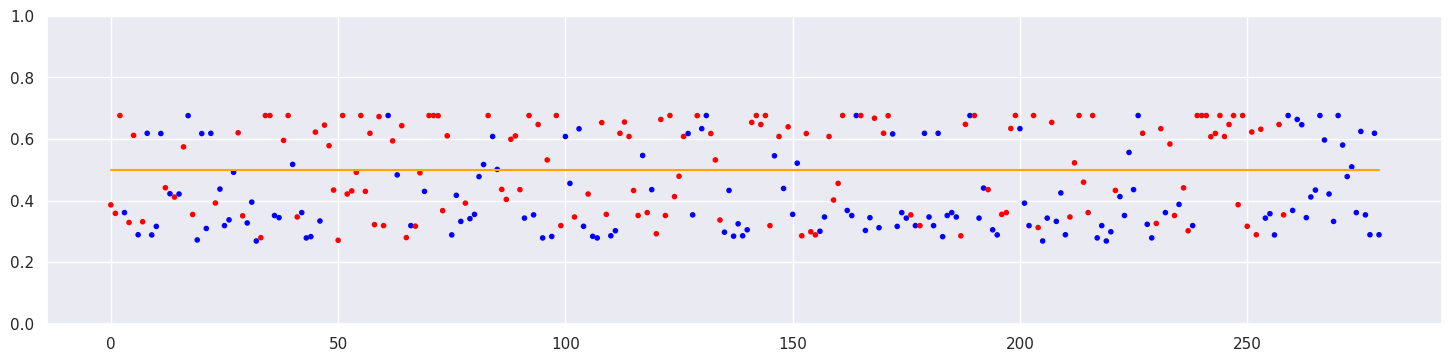

<Figure size 640x480 with 0 Axes>

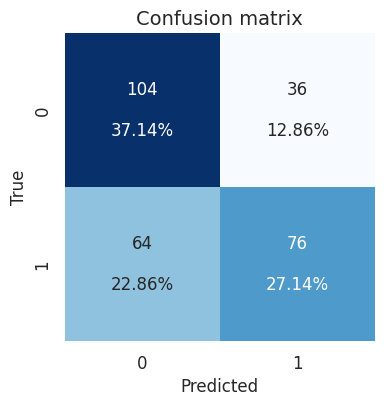

In [288]:
out_Y_org_wo_outliers = model1_v2.predict(test_data_wo_outliers_X, verbose=0)
out_Y_wo_outliers = [0 if x < 0.5 else 1 for x in out_Y_org_wo_outliers]

x = range(0, len(test_data_wo_outliers_Y))
fig = plt.figure(figsize=(18, 4))
colors = ['blue' if val == 0. else 'red' for val in np.asarray(test_data_wo_outliers_Y)]
plt.scatter(x, out_Y_org_wo_outliers, marker='.', label ='predicted', c=colors)
# plt.plot(x, test_Y, '.', label ='real')
plt.plot(x, [0.5] * len(test_Y), c='orange')
plt.ylim((0,1))

create_confusion_matrix(test_data_wo_outliers_Y, out_Y_wo_outliers)
get_model_metrics(test_data_wo_outliers_Y, out_Y_wo_outliers)